# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Importances](#Importances)
* [Discussion](#Discussion)

# Introduction

Earlier, the results of feature engineering were assessed with cross validation. This notebook extracts selected FRILL-based features from the whole dataset for prototyping.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# typing
from sklearn.base import BaseEstimator
from typing import Callable, Dict

# feature assessment
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.feature_selection import mutual_info_classif, SelectFromModel, SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# metrics
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%matplotlib widget  # for interactive plots

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.05 s


UsageError: unrecognized arguments: # for interactive plots


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location of pre-final features
FEATURES_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 93.7 ms


# Data loading

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    keep_columns = [
        "id",
        "source",
        "speaker_id",
        "speaker_gender",
        "emo",
        "valence",
        "lang1",
    ]
    labels = pd.concat(
        (
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
            ),
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/nondev_labels.feather", columns=keep_columns
            ),
        )
    ).set_index("id")
    return labels


def load_data(unscaled=False) -> pd.DataFrame:
    """Loads the FRILL data"""
    if unscaled:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/unscaled_features_ready_for_selection.feather"
        ).set_index("id")
    else:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/features_ready_for_selection.feather"
        ).set_index("id")
    df.columns = df.columns.astype(str)
    # df.columns = df.columns.str.replace(r"+", r"-", regex=True)
    return df


data = load_data()
labels = load_labels()
y_true = labels.valence

assert all(data.index == labels.index)
_ = gc_collect()

time: 256 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Columns: 118 entries, theta_LDA1+LDA2 to LDA-ocSVM_poly6_pos
dtypes: float64(118)
memory usage: 78.8 MB
<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          86752 non-null  category
 1   speaker_id      86752 non-null  category
 2   speaker_gender  86752 non-null  category
 3   emo             86752 non-null  category
 4   valence         86752 non-null  int8    
 5   lang1           86752 non-null  category
dtypes: category(5), int8(1)
memory usage: 1.3 MB
time: 29.8 ms


In [7]:
def plot_importances(
    fitted_tree: BaseEstimator, fig_height: int = 100, title: str = ""
) -> None:
    """Plot feature importances"""
    data = pd.Series(
        fitted_tree.feature_importances_, index=fitted_tree.feature_names_in_
    ).sort_values(ascending=False)
    plt.figure(figsize=(10, fig_height))
    sns.barplot(
        x=data.values,
        y=data.index,
        seed=SEED,
        palette="colorblind",
        linewidth=0,
    )
    sns.despine(top=True, right=True)
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def score_model(
    fitted_model: BaseEstimator, model_name: str = "", data: pd.DataFrame = data
) -> Dict[str, float]:
    """score a model with accuracy, auroc, and log losss"""
    scores = {}
    scores["accuracy"] = accuracy_score(y_true, fitted_model.predict(data))
    scores["roc_auc_ovo"] = roc_auc_score(
        y_true, _ := fitted_model.predict_proba(data), multi_class="ovo"
    )
    scores["log_loss"] = log_loss(y_true, _)
    print(model_name)
    for score in scores:
        print(f"{score}: {scores[score]:.4f}")
    return scores


def fit_trees(data: pd.DataFrame, y_true: pd.Series) -> Dict[str, BaseEstimator]:
    "fit selected tree ensembles"
    common_params = {
        "criterion": "entropy",
        "max_features": "sqrt",
        "random_state": SEED,
    }
    common_params2 = {
        **common_params,
        "max_depth": 15,
        "bootstrap": True,
        "oob_score": True,
        "n_jobs": -1,
        "class_weight": "balanced_subsample",
    }
    trees = {
        "AdaBoost": lambda: AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(
                splitter="random", max_depth=1, **common_params
            ),
            random_state=SEED,
        ),
        "ExtraTrees": lambda: ExtraTreesClassifier(**common_params2),
        "RandomForest": lambda: RandomForestClassifier(**common_params2),
    }
    return {k: v().fit(data, y_true) for k, v in trees.items()}


_ = gc_collect()

time: 115 ms


# Importances

Fit before

In [8]:
make_gnb: Callable = lambda: BaggingClassifier(
    base_estimator=GaussianNB(),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
)
fitted_models = {
    **(fitted_trees := fit_trees(data, y_true)),
    "GaussianNB": make_gnb().fit(data, y_true),
}

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


time: 1min 2s


Scores before

In [9]:
scores_before = {
    fitted_model: score_model(fitted_models[fitted_model], fitted_model)
    for fitted_model in fitted_models
}

AdaBoost
accuracy: 0.8686
roc_auc_ovo: 0.9062
log_loss: 0.9957
ExtraTrees
accuracy: 0.9530
roc_auc_ovo: 0.9967
log_loss: 0.1758


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9879
roc_auc_ovo: 0.9997
log_loss: 0.0849
GaussianNB
accuracy: 0.7829
roc_auc_ovo: 0.9360
log_loss: 4.4833
time: 23.6 s


out of bag scores (n/a for AdaBoost)

In [10]:
print("GaussianNB:", oob_gnb := fitted_models["GaussianNB"].oob_score_)
print("Extra Trees:", oob_extra := fitted_models["ExtraTrees"].oob_score_)
print("Random Forest:", oob_rf := fitted_models["RandomForest"].oob_score_)

GaussianNB: 0.7827715787532276
Extra Trees: 0.9115639985245297
Random Forest: 0.927114072298045
time: 6 ms


Importances before

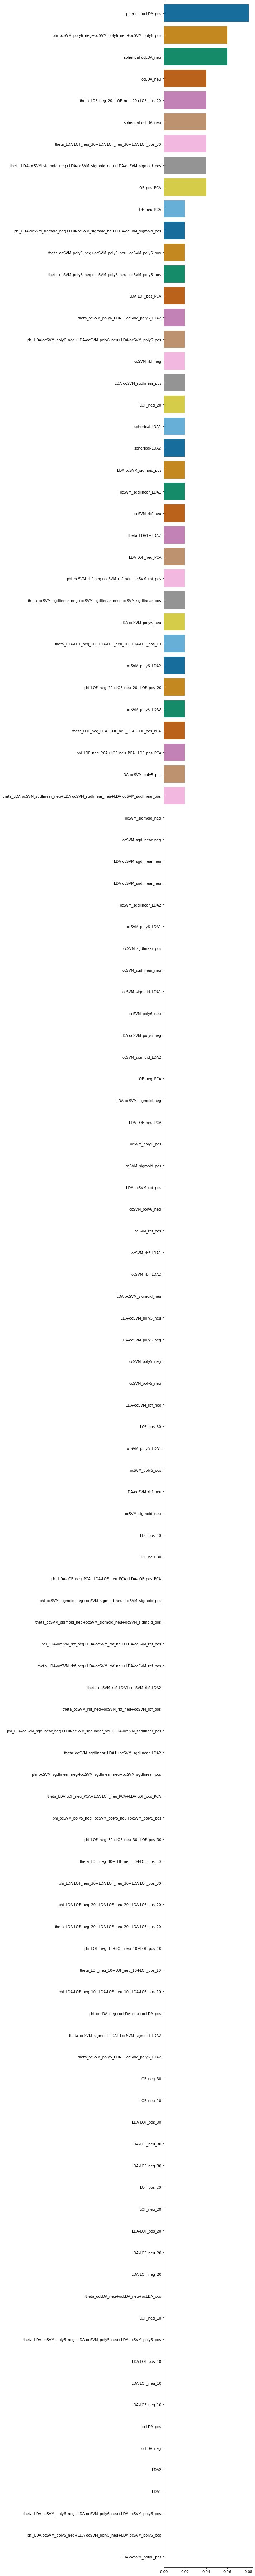

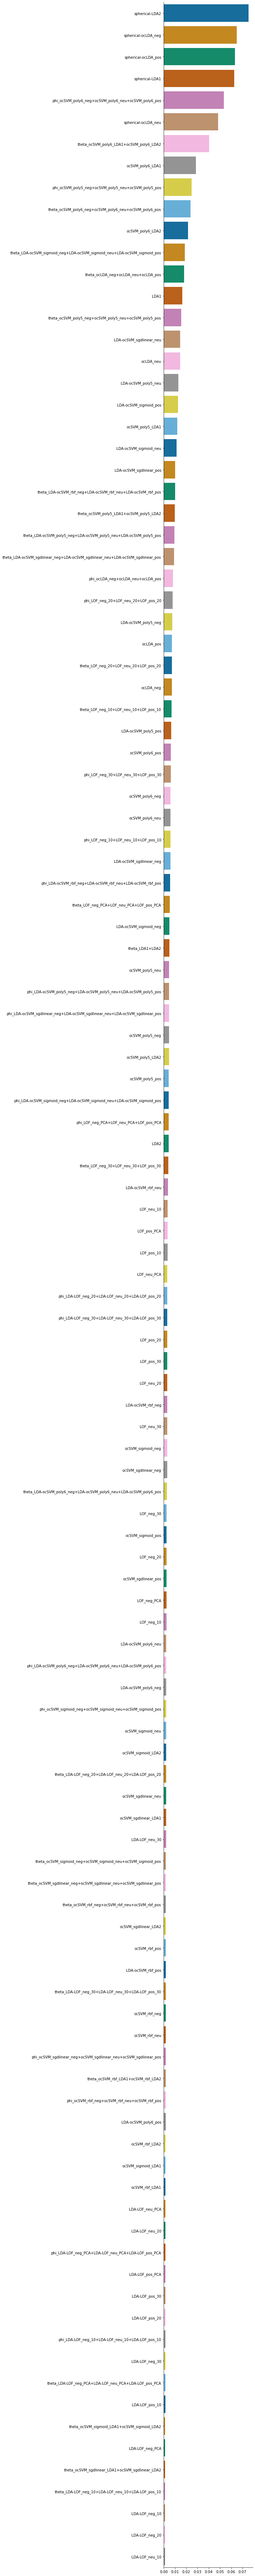

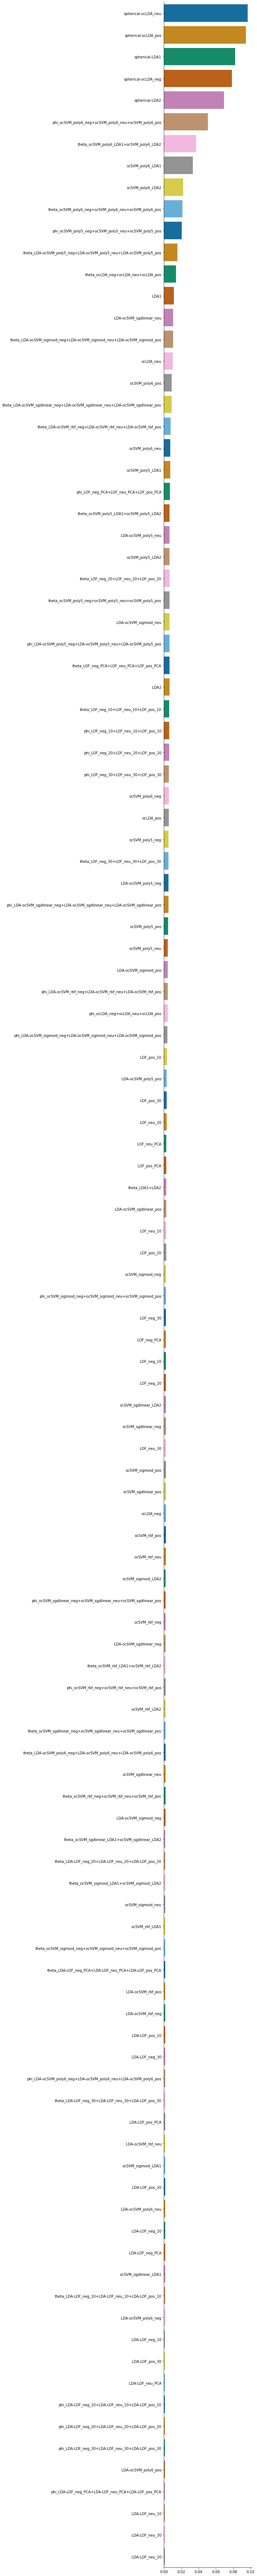

time: 10.6 s


In [11]:
for fitted_tree in fitted_trees:
    plot_importances(fitted_trees[fitted_tree])

Select features

The big spherical LDA components are always in the top. LOF-based features are usually near the bottom. Certain poly6 features are usually the runner up (but not all).

In [12]:
selected_features = {
    "five_sphericals": [
        "spherical-LDA1",
        "spherical-LDA2",
        "spherical-ocLDA_neg",
        "spherical-ocLDA_neu",
        "spherical-ocLDA_pos",
    ],
    "poly6_subset": [
        "ocSVM_poly6_LDA1",
        "ocSVM_poly6_LDA2",
        "phi_ocSVM_poly6_neg+ocSVM_poly6_neu+ocSVM_poly6_pos",
        "theta_ocSVM_poly6_neg+ocSVM_poly6_neu+ocSVM_poly6_pos",
        "theta_ocSVM_poly6_LDA1+ocSVM_poly6_LDA2",
    ],
}
selected_features["five_sphericals+poly6_subset"] = (
    selected_features["five_sphericals"] + selected_features["poly6_subset"]
)
selected_features["three_sphericals"] = [
    "spherical-ocLDA_neg",
    "spherical-ocLDA_neu",
    "spherical-ocLDA_pos",
]
selected_features["two_sphericals"] = ["spherical-LDA1", "spherical-LDA2"]

_ = gc_collect()

time: 154 ms


After

features: five_sphericals


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost
accuracy: 0.8745
roc_auc_ovo: 0.8748
log_loss: 0.9264
ExtraTrees
accuracy: 0.9025
roc_auc_ovo: 0.9864
log_loss: 0.2345


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9289
roc_auc_ovo: 0.9930
log_loss: 0.1820
GaussianNB
accuracy: 0.8706
roc_auc_ovo: 0.9729
log_loss: 0.6322

GaussianNB oob score changed by 0.0878 to 0.8706
extra trees oob score changed by -0.0339 to 0.8777
random forest oob score changed by -0.0503 to 0.8768

AdaBoost
accuracy changed by 0.0059 to 0.8745
roc_auc_ovo changed by -0.0314 to 0.8748
log_loss changed by -0.0693 to 0.9264

ExtraTrees
accuracy changed by -0.0505 to 0.9025
roc_auc_ovo changed by -0.0103 to 0.9864
log_loss changed by 0.0587 to 0.2345

RandomForest
accuracy changed by -0.0590 to 0.9289
roc_auc_ovo changed by -0.0067 to 0.9930
log_loss changed by 0.0971 to 0.1820

GaussianNB
accuracy changed by 0.0877 to 0.8706
roc_auc_ovo changed by 0.0369 to 0.9729
log_loss changed by -3.8511 to 0.6322



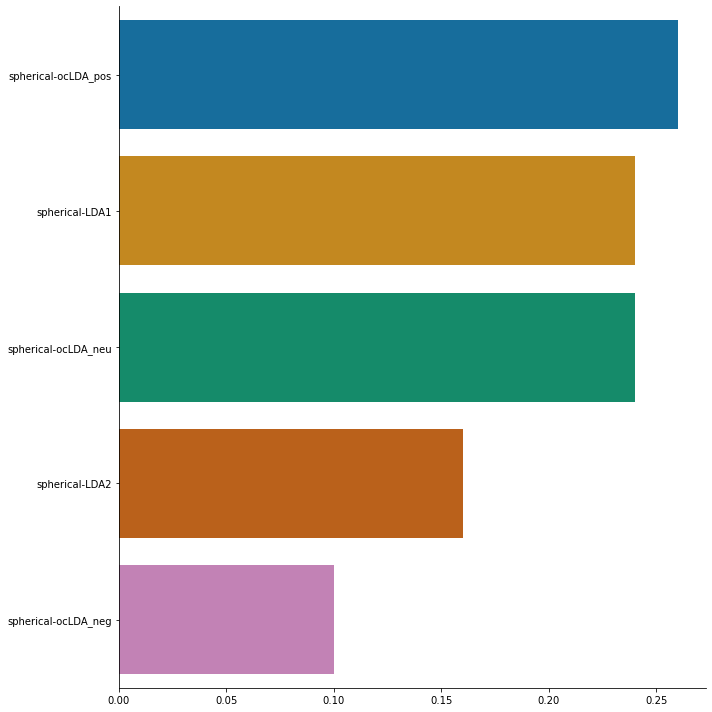

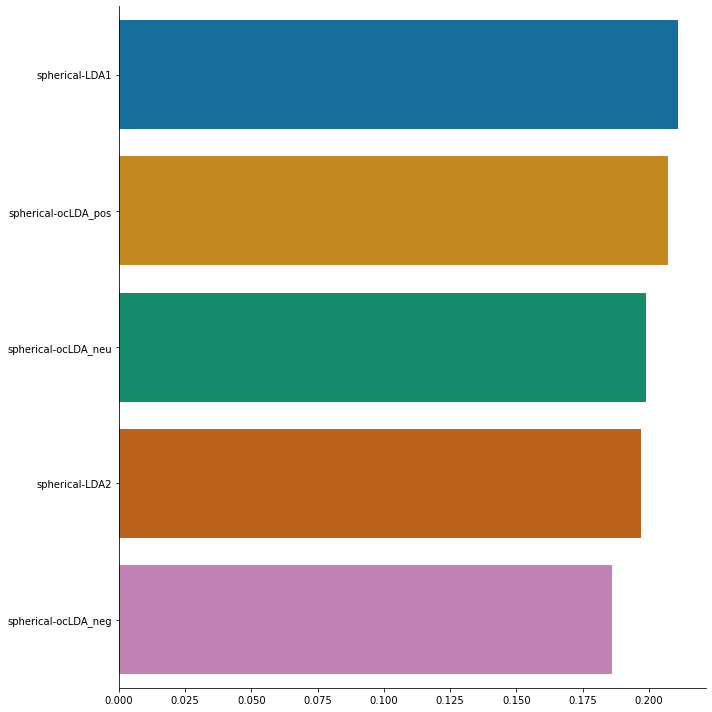

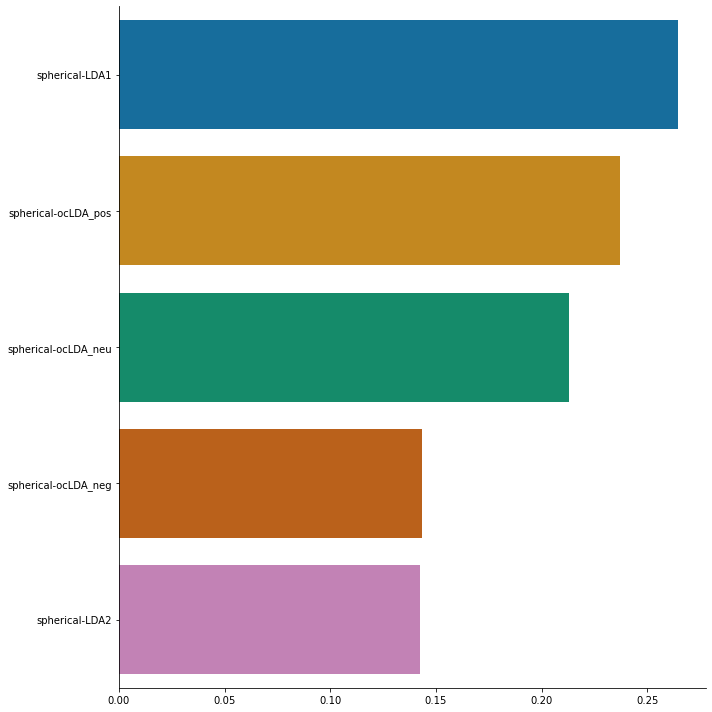

features: poly6_subset


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost
accuracy: 0.8135
roc_auc_ovo: 0.8945
log_loss: 1.0289
ExtraTrees
accuracy: 0.8675
roc_auc_ovo: 0.9793
log_loss: 0.3025


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9199
roc_auc_ovo: 0.9922
log_loss: 0.2125
GaussianNB
accuracy: 0.7556
roc_auc_ovo: 0.9356
log_loss: 0.8369

GaussianNB oob score changed by -0.0273 to 0.7555
extra trees oob score changed by -0.0780 to 0.8336
random forest oob score changed by -0.0913 to 0.8358

AdaBoost
accuracy changed by -0.0551 to 0.8135
roc_auc_ovo changed by -0.0117 to 0.8945
log_loss changed by 0.0332 to 1.0289

ExtraTrees
accuracy changed by -0.0855 to 0.8675
roc_auc_ovo changed by -0.0174 to 0.9793
log_loss changed by 0.1267 to 0.3025

RandomForest
accuracy changed by -0.0681 to 0.9199
roc_auc_ovo changed by -0.0075 to 0.9922
log_loss changed by 0.1276 to 0.2125

GaussianNB
accuracy changed by -0.0272 to 0.7556
roc_auc_ovo changed by -0.0004 to 0.9356
log_loss changed by -3.6465 to 0.8369



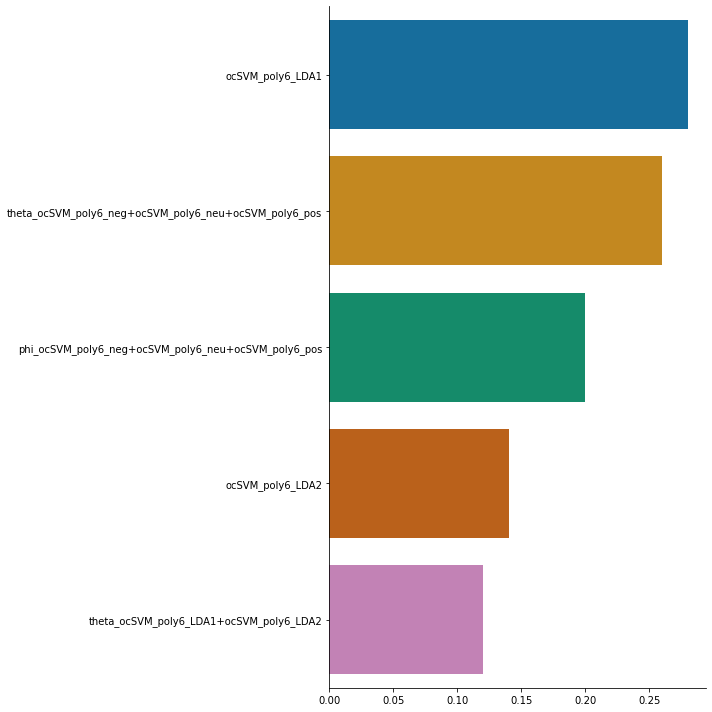

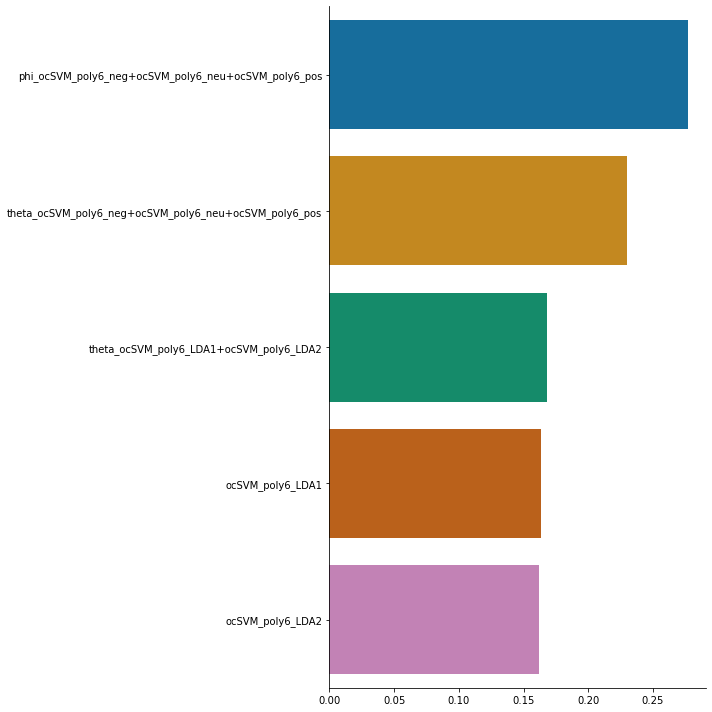

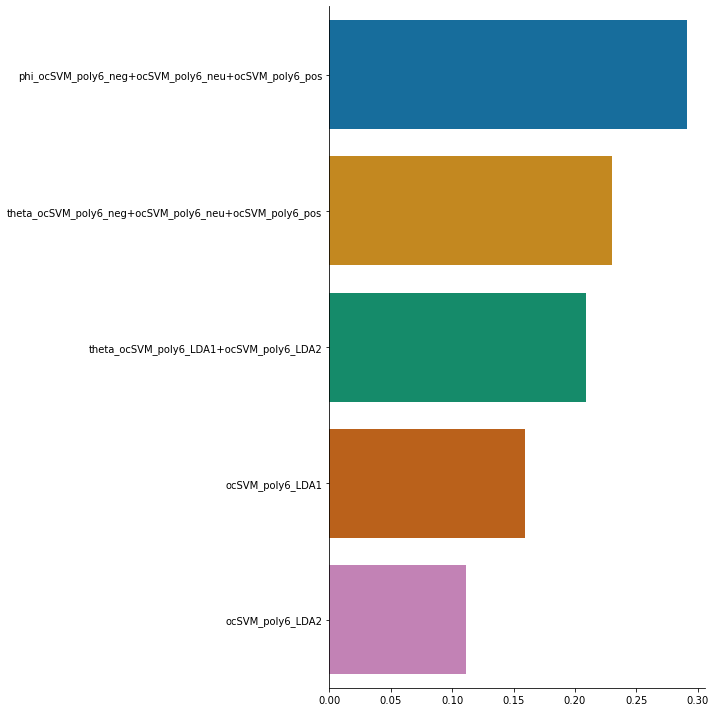

features: five_sphericals+poly6_subset


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost
accuracy: 0.8855
roc_auc_ovo: 0.8781
log_loss: 0.9348
ExtraTrees
accuracy: 0.9155
roc_auc_ovo: 0.9904
log_loss: 0.2071


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9581
roc_auc_ovo: 0.9973
log_loss: 0.1345
GaussianNB
accuracy: 0.8617
roc_auc_ovo: 0.9720
log_loss: 0.9928

GaussianNB oob score changed by 0.0789 to 0.8617
extra trees oob score changed by -0.0218 to 0.8898
random forest oob score changed by -0.0320 to 0.8952

AdaBoost
accuracy changed by 0.0169 to 0.8855
roc_auc_ovo changed by -0.0280 to 0.8781
log_loss changed by -0.0609 to 0.9348

ExtraTrees
accuracy changed by -0.0375 to 0.9155
roc_auc_ovo changed by -0.0063 to 0.9904
log_loss changed by 0.0313 to 0.2071

RandomForest
accuracy changed by -0.0298 to 0.9581
roc_auc_ovo changed by -0.0024 to 0.9973
log_loss changed by 0.0496 to 0.1345

GaussianNB
accuracy changed by 0.0788 to 0.8617
roc_auc_ovo changed by 0.0359 to 0.9720
log_loss changed by -3.4905 to 0.9928



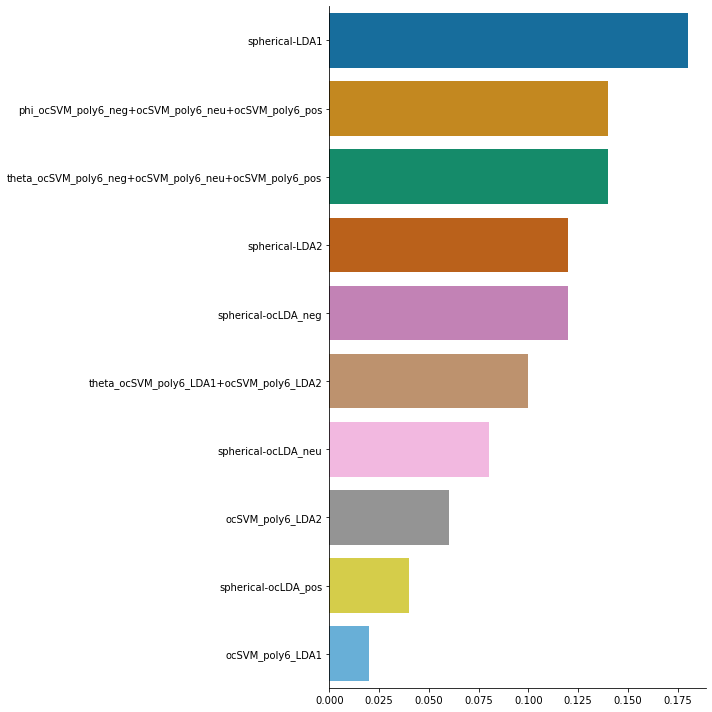

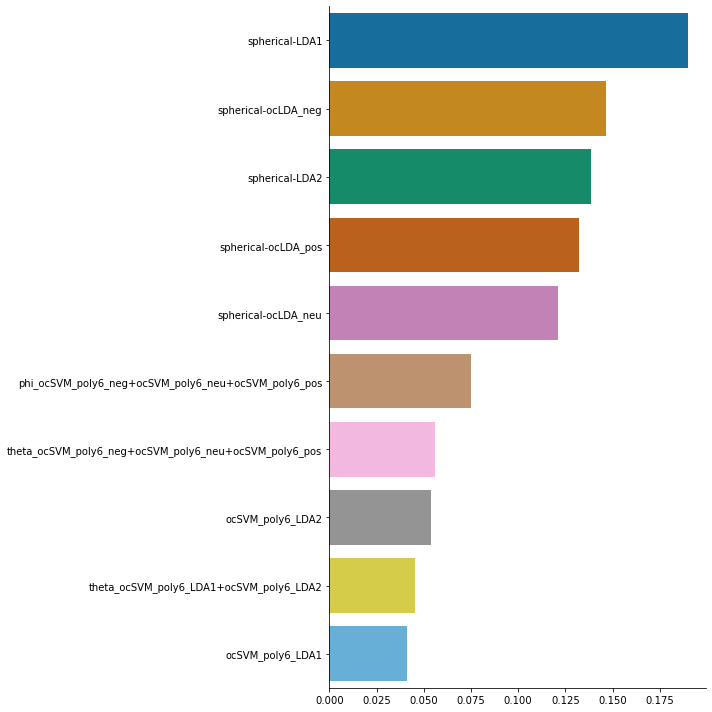

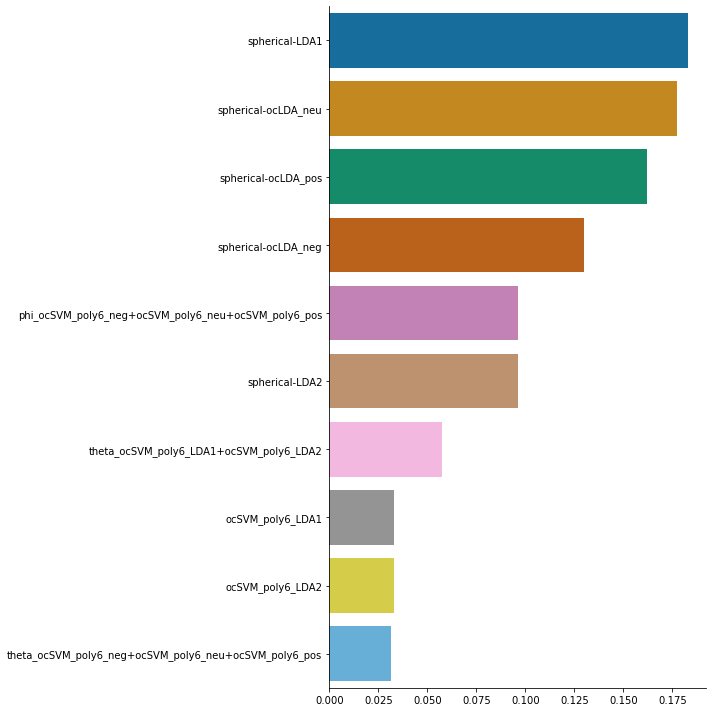

features: three_sphericals


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost
accuracy: 0.8632
roc_auc_ovo: 0.9014
log_loss: 0.9544
ExtraTrees
accuracy: 0.8868
roc_auc_ovo: 0.9820
log_loss: 0.2689


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9283
roc_auc_ovo: 0.9927
log_loss: 0.1844
GaussianNB
accuracy: 0.8725
roc_auc_ovo: 0.9723
log_loss: 0.3924

GaussianNB oob score changed by 0.0897 to 0.8725
extra trees oob score changed by -0.0372 to 0.8744
random forest oob score changed by -0.0501 to 0.8770

AdaBoost
accuracy changed by -0.0054 to 0.8632
roc_auc_ovo changed by -0.0047 to 0.9014
log_loss changed by -0.0412 to 0.9544

ExtraTrees
accuracy changed by -0.0662 to 0.8868
roc_auc_ovo changed by -0.0147 to 0.9820
log_loss changed by 0.0931 to 0.2689

RandomForest
accuracy changed by -0.0597 to 0.9283
roc_auc_ovo changed by -0.0070 to 0.9927
log_loss changed by 0.0995 to 0.1844

GaussianNB
accuracy changed by 0.0896 to 0.8725
roc_auc_ovo changed by 0.0363 to 0.9723
log_loss changed by -4.0910 to 0.3924



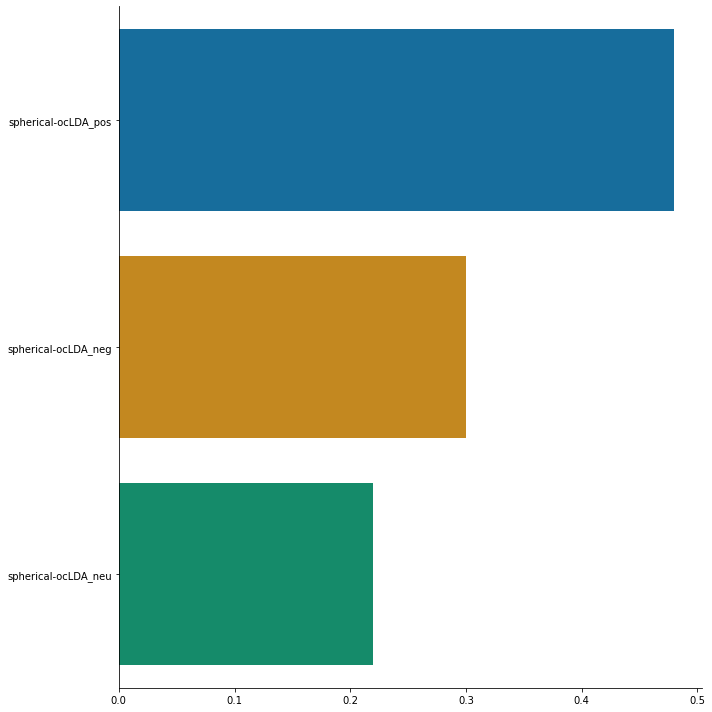

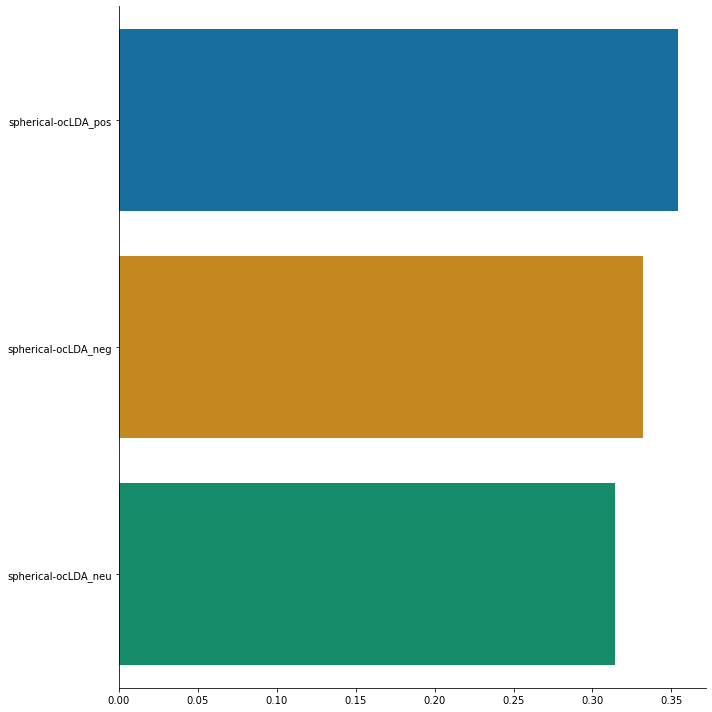

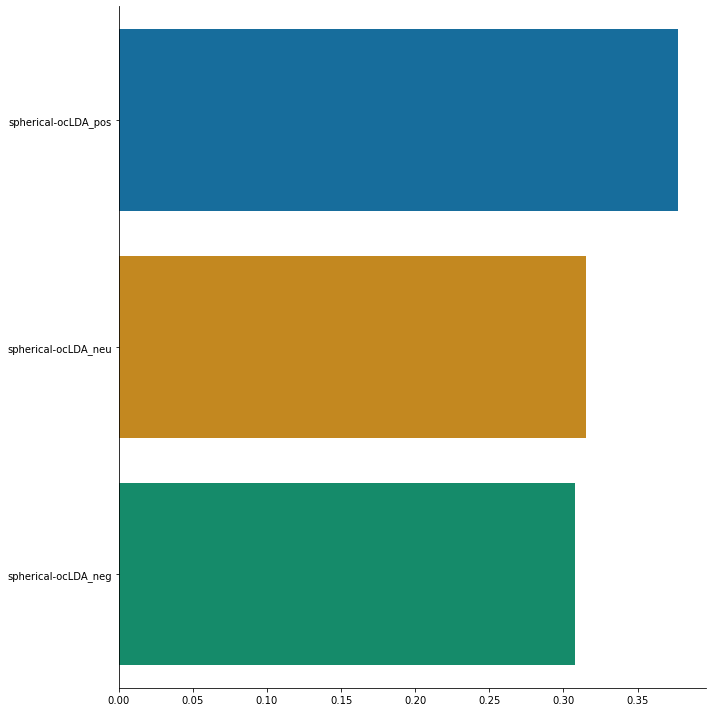

features: two_sphericals


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost
accuracy: 0.8644
roc_auc_ovo: 0.8669
log_loss: 0.9546
ExtraTrees
accuracy: 0.8948
roc_auc_ovo: 0.9836
log_loss: 0.2596


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9209
roc_auc_ovo: 0.9916
log_loss: 0.1933
GaussianNB
accuracy: 0.8756
roc_auc_ovo: 0.9704
log_loss: 0.3578

GaussianNB oob score changed by 0.0930 to 0.8757
extra trees oob score changed by -0.0362 to 0.8754
random forest oob score changed by -0.0509 to 0.8762

AdaBoost
accuracy changed by -0.0042 to 0.8644
roc_auc_ovo changed by -0.0393 to 0.8669
log_loss changed by -0.0411 to 0.9546

ExtraTrees
accuracy changed by -0.0582 to 0.8948
roc_auc_ovo changed by -0.0131 to 0.9836
log_loss changed by 0.0838 to 0.2596

RandomForest
accuracy changed by -0.0670 to 0.9209
roc_auc_ovo changed by -0.0081 to 0.9916
log_loss changed by 0.1084 to 0.1933

GaussianNB
accuracy changed by 0.0928 to 0.8756
roc_auc_ovo changed by 0.0343 to 0.9704
log_loss changed by -4.1256 to 0.3578



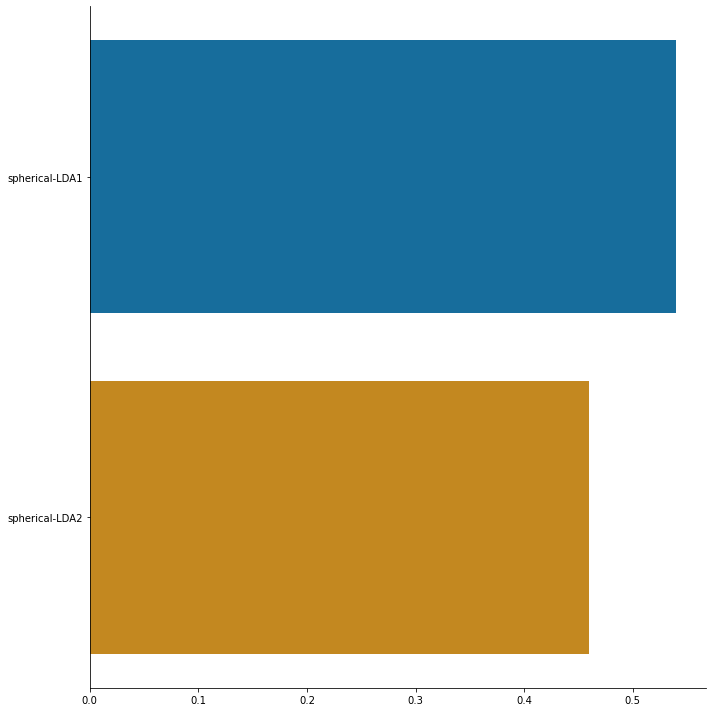

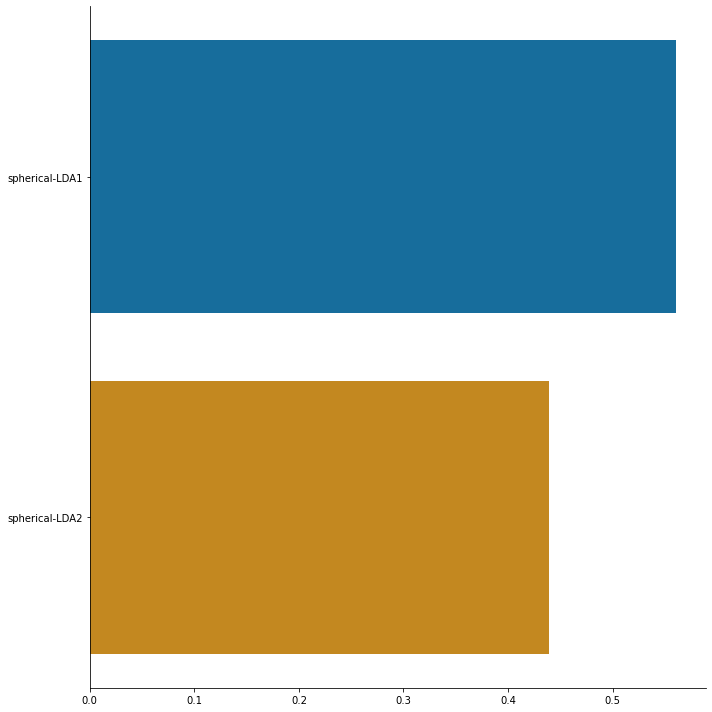

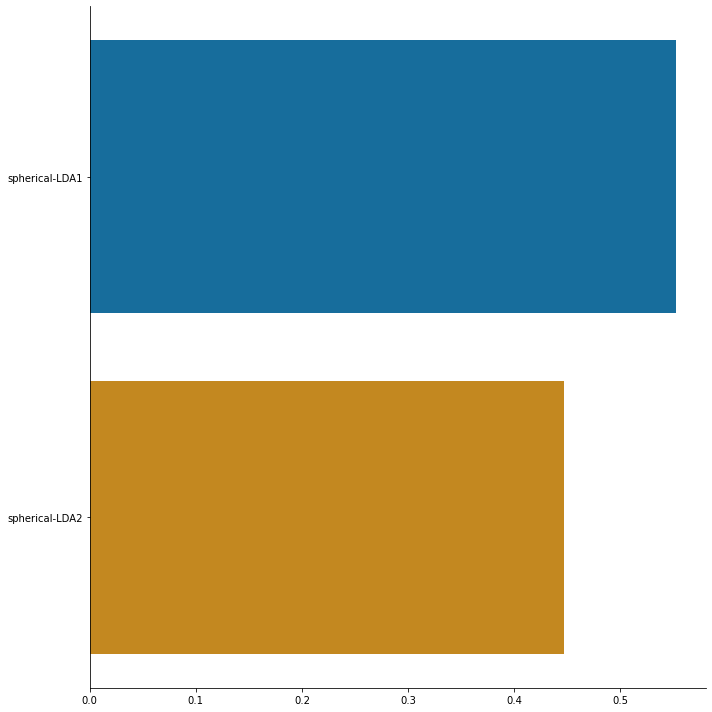

time: 1min 33s


In [13]:
for selected in selected_features.keys():
    print("features:", selected)
    data = load_data().loc[:, selected_features[selected]]
    fitted_models = {
        **(fitted_trees := fit_trees(data, y_true)),
        "GaussianNB": make_gnb().fit(data, y_true),
    }
    scores_after = {k: score_model(v, k, data) for k, v in fitted_models.items()}
    print()
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models['GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_trees['ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_trees['RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()
    for model in fitted_models.keys():
        before = scores_before[model]
        after = scores_after[model]
        print(model)
        for score in ("accuracy", "roc_auc_ovo", "log_loss"):
            print(
                f"{score} changed by {after[score] - before[score]:.4f} to {after[score]:.4f}"
            )
        print()
    for fitted_tree in fitted_trees:
        plot_importances(fitted_trees[fitted_tree], fig_height=10)

SelectFromModel

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


selecting with AdaBoost


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


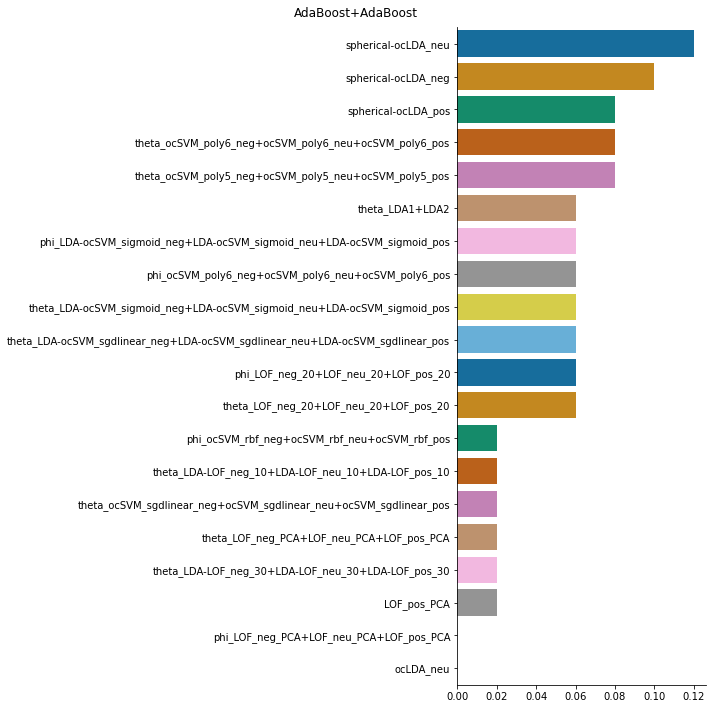

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


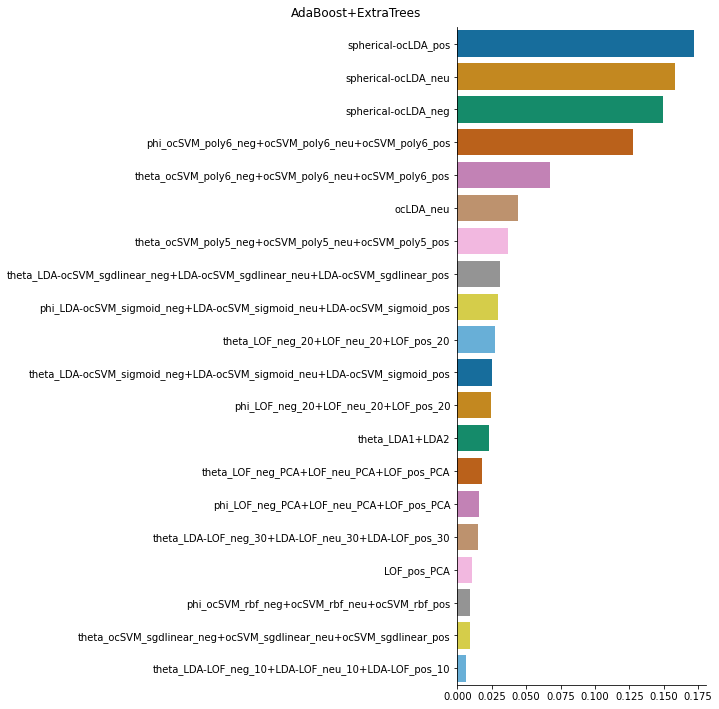

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


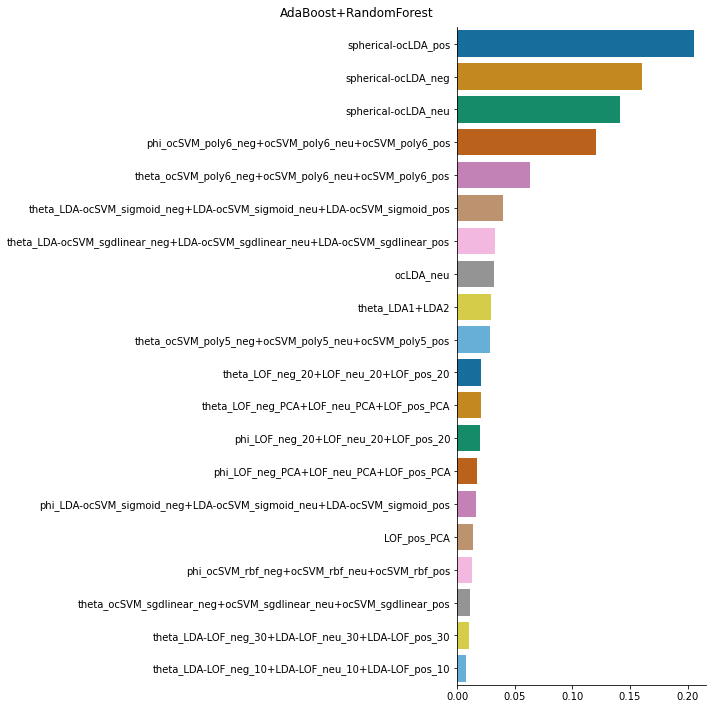

GaussianNB oob score changed by 0.0258 to 0.8086
extra trees oob score changed by -0.0051 to 0.9064
random forest oob score changed by -0.0055 to 0.9216

AdaBoost+AdaBoost
accuracy: 0.8772
roc_auc_ovo: 0.9371
log_loss: 1.0144
AdaBoost+ExtraTrees
accuracy: 0.9332
roc_auc_ovo: 0.9935
log_loss: 0.1983


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost+RandomForest
accuracy: 0.9779
roc_auc_ovo: 0.9992
log_loss: 0.0984
AdaBoost+GaussianNB
accuracy: 0.8086
roc_auc_ovo: 0.9547
log_loss: 1.3115

with feature selection by AdaBoost...
AdaBoost's accuracy changed by 0.0086 from 0.8686 to 0.8772
AdaBoost's roc_auc_ovo changed by 0.0310 from 0.9062 to 0.9371
AdaBoost's log_loss changed by 0.0188 from 0.9957 to 1.0144
ExtraTrees's accuracy changed by -0.0198 from 0.9530 to 0.9332
ExtraTrees's roc_auc_ovo changed by -0.0032 from 0.9967 to 0.9935
ExtraTrees's log_loss changed by 0.0225 from 0.1758 to 0.1983
RandomForest's accuracy changed by -0.0100 from 0.9879 to 0.9779
RandomForest's roc_auc_ovo changed by -0.0005 from 0.9997 to 0.9992
RandomForest's log_loss changed by 0.0135 from 0.0849 to 0.0984
GaussianNB's accuracy changed by 0.0257 from 0.7829 to 0.8086
GaussianNB's roc_auc_ovo changed by 0.0187 from 0.9360 to 0.9547
GaussianNB's log_loss changed by -3.1718 from 4.4833 to 1.3115

selecting with ExtraTrees


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


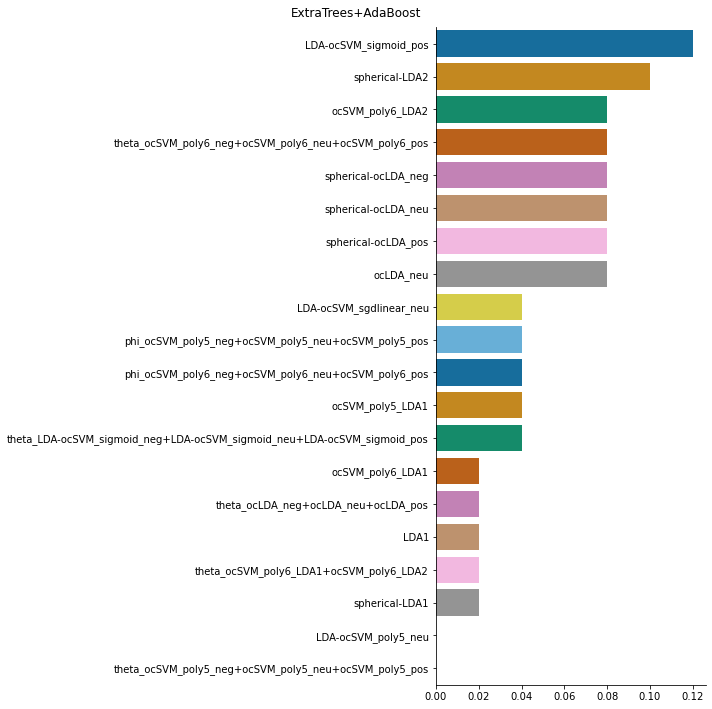

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


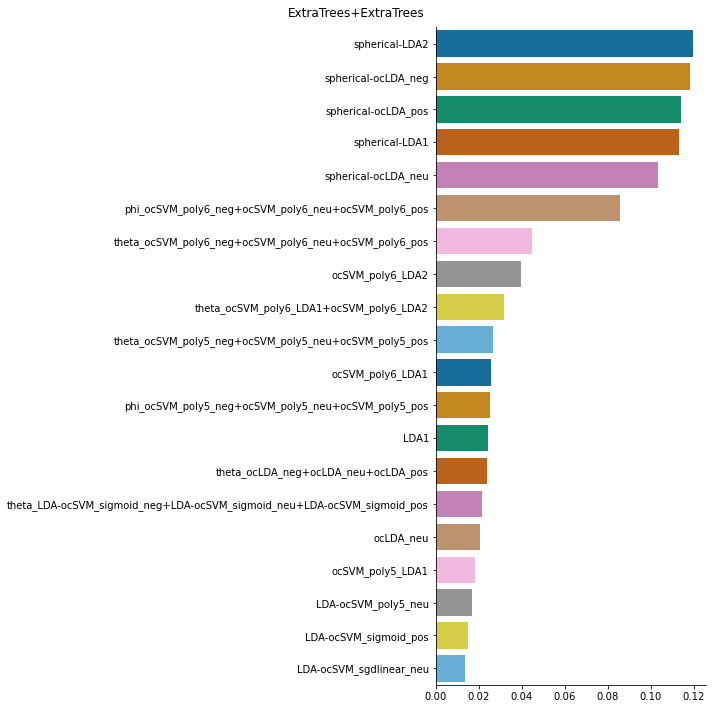

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


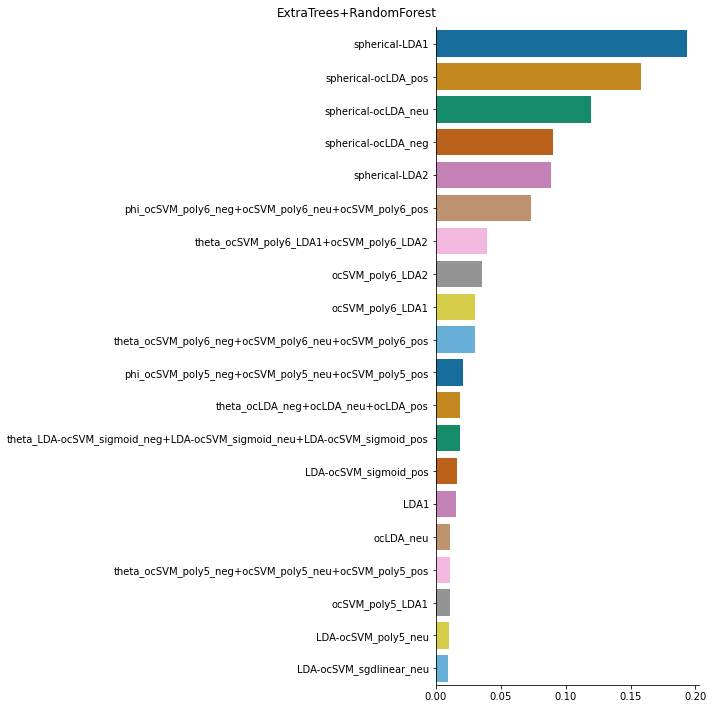

GaussianNB oob score changed by 0.0410 to 0.8238
extra trees oob score changed by -0.0113 to 0.9003
random forest oob score changed by -0.0166 to 0.9105

ExtraTrees+AdaBoost
accuracy: 0.8595
roc_auc_ovo: 0.8753
log_loss: 0.9843
ExtraTrees+ExtraTrees
accuracy: 0.9256
roc_auc_ovo: 0.9923
log_loss: 0.1968


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ExtraTrees+RandomForest
accuracy: 0.9700
roc_auc_ovo: 0.9986
log_loss: 0.1133
ExtraTrees+GaussianNB
accuracy: 0.8237
roc_auc_ovo: 0.9598
log_loss: 1.9240

with feature selection by ExtraTrees...
AdaBoost's accuracy changed by -0.0091 from 0.8686 to 0.8595
AdaBoost's roc_auc_ovo changed by -0.0309 from 0.9062 to 0.8753
AdaBoost's log_loss changed by -0.0114 from 0.9957 to 0.9843
ExtraTrees's accuracy changed by -0.0274 from 0.9530 to 0.9256
ExtraTrees's roc_auc_ovo changed by -0.0044 from 0.9967 to 0.9923
ExtraTrees's log_loss changed by 0.0209 from 0.1758 to 0.1968
RandomForest's accuracy changed by -0.0179 from 0.9879 to 0.9700
RandomForest's roc_auc_ovo changed by -0.0011 from 0.9997 to 0.9986
RandomForest's log_loss changed by 0.0284 from 0.0849 to 0.1133
GaussianNB's accuracy changed by 0.0409 from 0.7829 to 0.8237
GaussianNB's roc_auc_ovo changed by 0.0237 from 0.9360 to 0.9598
GaussianNB's log_loss changed by -2.5594 from 4.4833 to 1.9240

selecting with RandomForest


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


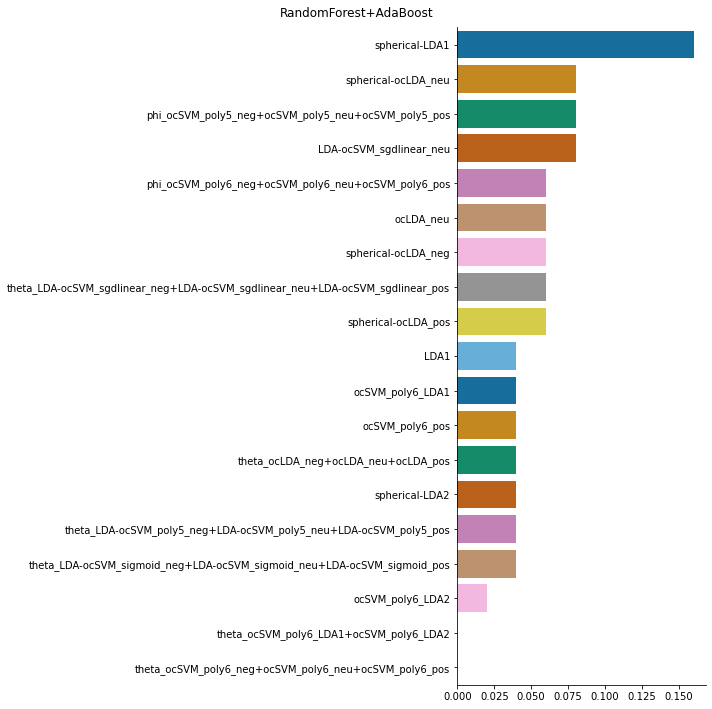

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


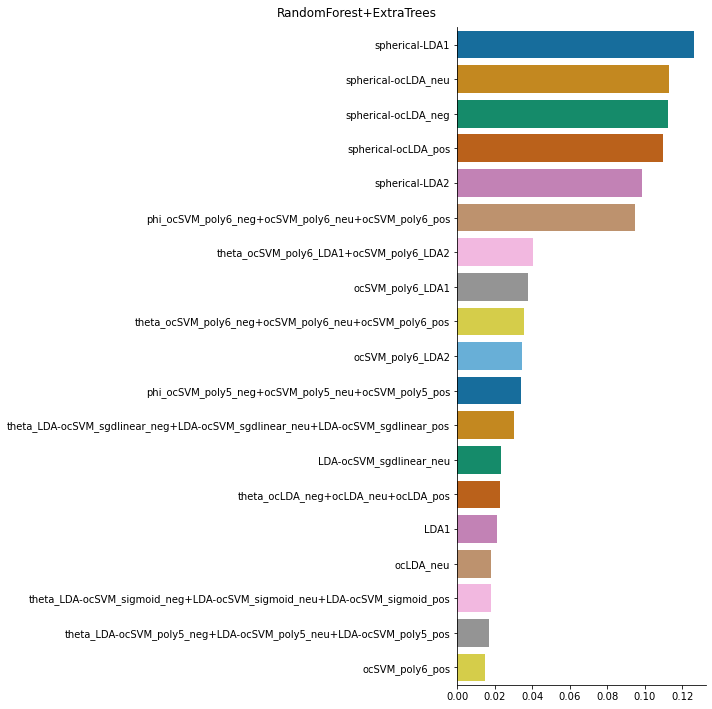

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


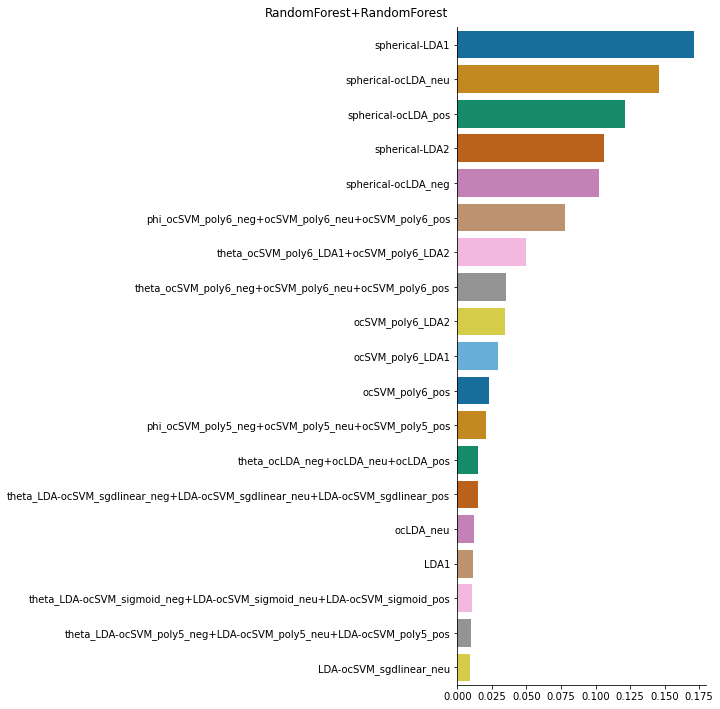

GaussianNB oob score changed by 0.0407 to 0.8234
extra trees oob score changed by -0.0094 to 0.9021
random forest oob score changed by -0.0145 to 0.9126

RandomForest+AdaBoost
accuracy: 0.8651
roc_auc_ovo: 0.8799
log_loss: 1.0003
RandomForest+ExtraTrees
accuracy: 0.9268
roc_auc_ovo: 0.9927
log_loss: 0.1921


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest+RandomForest
accuracy: 0.9699
roc_auc_ovo: 0.9986
log_loss: 0.1111
RandomForest+GaussianNB
accuracy: 0.8235
roc_auc_ovo: 0.9611
log_loss: 1.8287

with feature selection by RandomForest...
AdaBoost's accuracy changed by -0.0035 from 0.8686 to 0.8651
AdaBoost's roc_auc_ovo changed by -0.0263 from 0.9062 to 0.8799
AdaBoost's log_loss changed by 0.0046 from 0.9957 to 1.0003
ExtraTrees's accuracy changed by -0.0262 from 0.9530 to 0.9268
ExtraTrees's roc_auc_ovo changed by -0.0040 from 0.9967 to 0.9927
ExtraTrees's log_loss changed by 0.0163 from 0.1758 to 0.1921
RandomForest's accuracy changed by -0.0180 from 0.9879 to 0.9699
RandomForest's roc_auc_ovo changed by -0.0012 from 0.9997 to 0.9986
RandomForest's log_loss changed by 0.0262 from 0.0849 to 0.1111
GaussianNB's accuracy changed by 0.0407 from 0.7829 to 0.8235
GaussianNB's roc_auc_ovo changed by 0.0250 from 0.9360 to 0.9611
GaussianNB's log_loss changed by -2.6547 from 4.4833 to 1.8287

time: 2min 13s


In [14]:
data = load_data()
fitted_trees = fit_trees(data, y_true)
selectors = {
    model_name: SelectFromModel(estimator=fitted_model, prefit=True, max_features=20)
    for model_name, fitted_model in fitted_trees.items()
}
for selector_estimator, selector in selectors.items():
    print(f"selecting with {selector_estimator}")

    data_ = pd.DataFrame(
        selector.transform(data), columns=selector.get_feature_names_out(data.columns)
    )
    fitted_models: Dict[str, BaseEstimator] = {}

    for ensemble_name, fitted_tree in deepcopy(fitted_trees).items():
        fitted_models[
            f"{selector_estimator}+{ensemble_name}"
        ] = fitted_tree.fit(  # re-fit
            data_, y_true
        )
        plot_importances(
            fitted_tree, fig_height=10, title=f"{selector_estimator}+{ensemble_name}"
        )
    fitted_models[f"{selector_estimator}+GaussianNB"] = make_gnb().fit(data_, y_true)
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models[f'{selector_estimator}+GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_models[f'{selector_estimator}+ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_models[f'{selector_estimator}+RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()

    scores_after: Dict[str, Dict[str, float]] = {
        k: score_model(v, k, data=data_) for k, v in fitted_models.items()
    }

    print(f"\nwith feature selection by {selector_estimator}...")
    for after_model, after_score_dict in scores_before.items():
        after_scores: Dict[str, float] = scores_after[
            f"{selector_estimator}+{after_model}"
        ]
        before_scores: Dict[str, float] = scores_before[after_model]
        base_model = after_model.split("+")[-1]
        for scorer, score in after_scores.items():
            print(
                f"{base_model}'s {scorer} changed by {(after := after_scores[scorer]) - (before := before_scores[scorer]):.4f} from {before:.4f} to {after:.4f}"
            )
    print()

Once more with max_features=18

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


selecting with AdaBoost


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


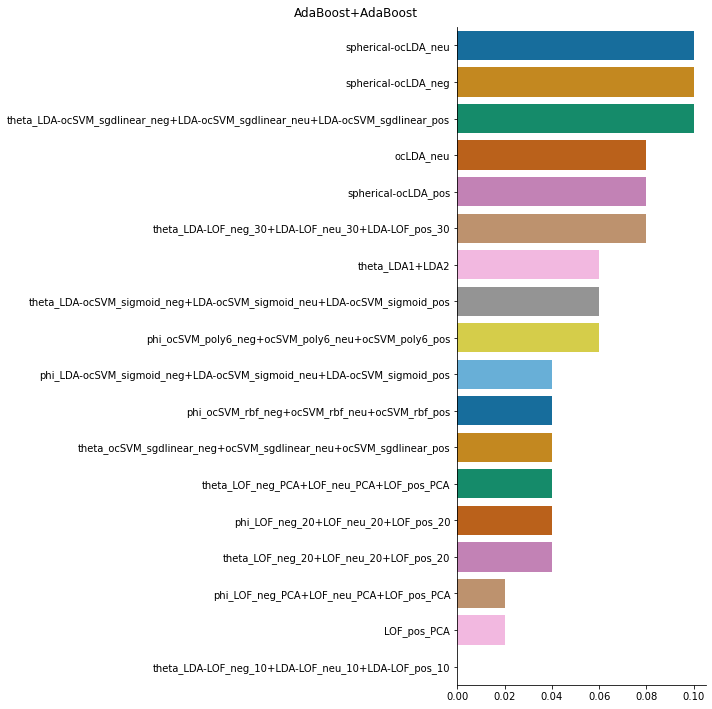

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


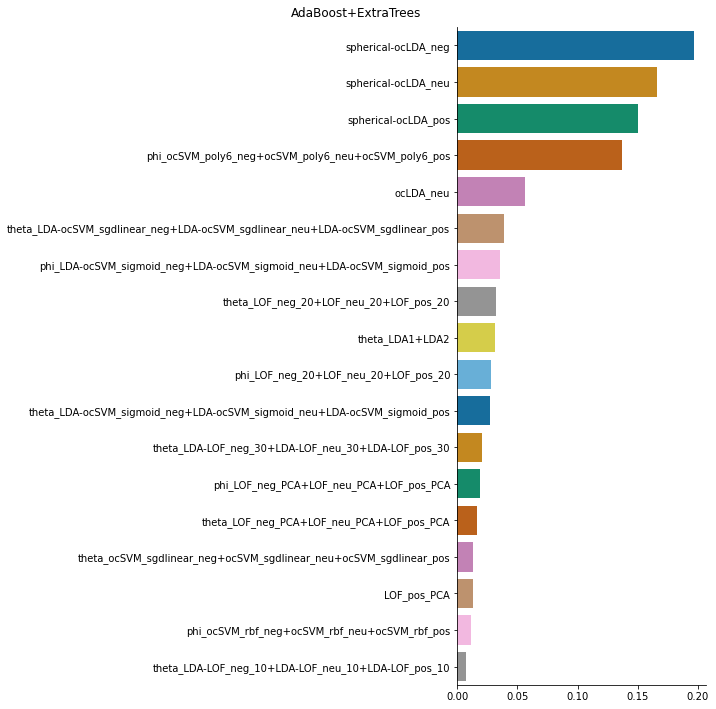

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


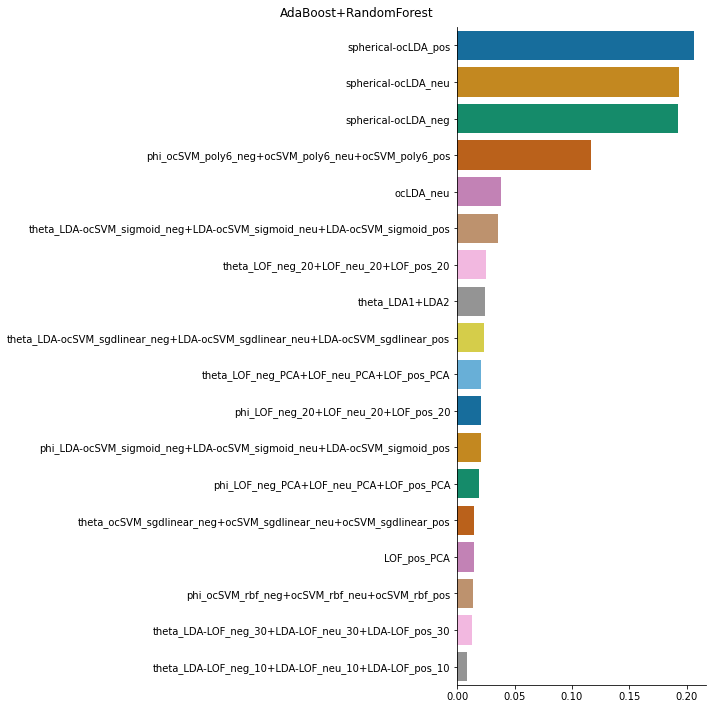

GaussianNB oob score changed by 0.0266 to 0.8094
extra trees oob score changed by -0.0055 to 0.9061
random forest oob score changed by -0.0072 to 0.9199

AdaBoost+AdaBoost
accuracy: 0.8720
roc_auc_ovo: 0.9280
log_loss: 1.0183
AdaBoost+ExtraTrees
accuracy: 0.9338
roc_auc_ovo: 0.9936
log_loss: 0.1980


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost+RandomForest
accuracy: 0.9785
roc_auc_ovo: 0.9992
log_loss: 0.0978
AdaBoost+GaussianNB
accuracy: 0.8096
roc_auc_ovo: 0.9561
log_loss: 1.1867

with feature selection by AdaBoost...
AdaBoost's accuracy changed by 0.0034 from 0.8686 to 0.8720
AdaBoost's roc_auc_ovo changed by 0.0218 from 0.9062 to 0.9280
AdaBoost's log_loss changed by 0.0227 from 0.9957 to 1.0183
ExtraTrees's accuracy changed by -0.0193 from 0.9530 to 0.9338
ExtraTrees's roc_auc_ovo changed by -0.0031 from 0.9967 to 0.9936
ExtraTrees's log_loss changed by 0.0222 from 0.1758 to 0.1980
RandomForest's accuracy changed by -0.0094 from 0.9879 to 0.9785
RandomForest's roc_auc_ovo changed by -0.0005 from 0.9997 to 0.9992
RandomForest's log_loss changed by 0.0129 from 0.0849 to 0.0978
GaussianNB's accuracy changed by 0.0268 from 0.7829 to 0.8096
GaussianNB's roc_auc_ovo changed by 0.0201 from 0.9360 to 0.9561
GaussianNB's log_loss changed by -3.2966 from 4.4833 to 1.1867

selecting with ExtraTrees


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


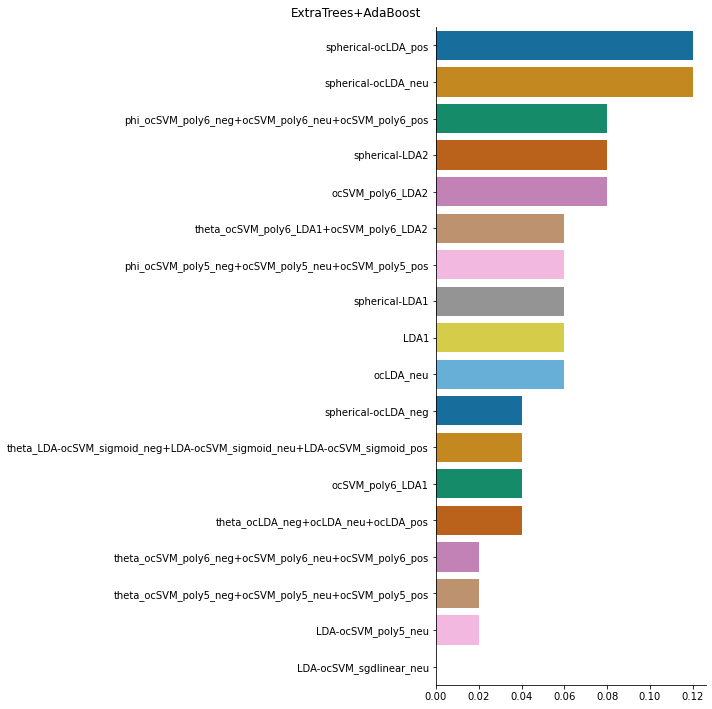

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


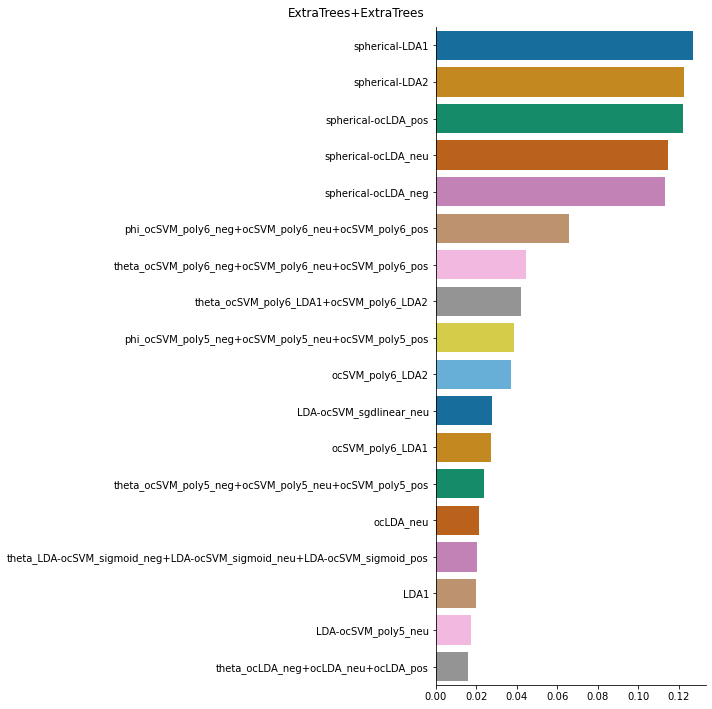

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


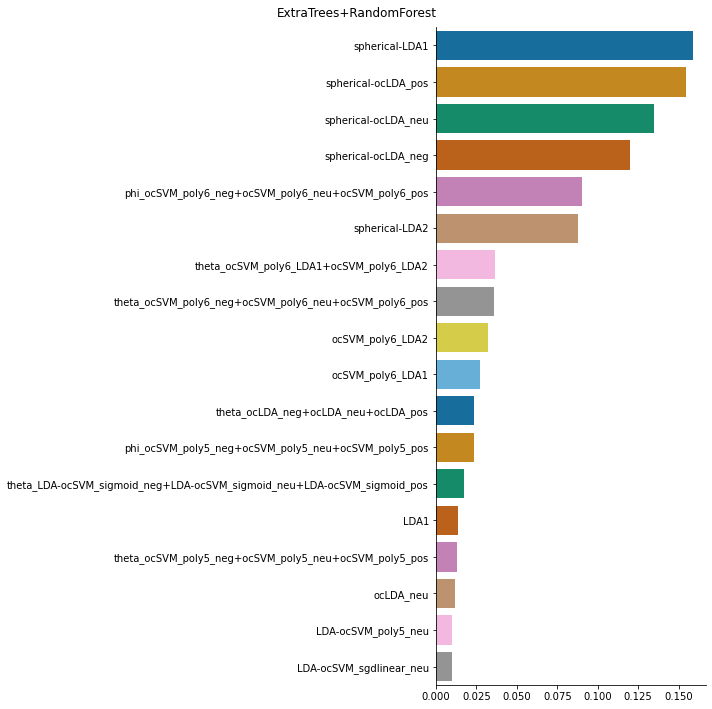

GaussianNB oob score changed by 0.0461 to 0.8289
extra trees oob score changed by -0.0119 to 0.8997
random forest oob score changed by -0.0176 to 0.9095

ExtraTrees+AdaBoost
accuracy: 0.8483
roc_auc_ovo: 0.8785
log_loss: 0.9764
ExtraTrees+ExtraTrees
accuracy: 0.9250
roc_auc_ovo: 0.9921
log_loss: 0.1965


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ExtraTrees+RandomForest
accuracy: 0.9697
roc_auc_ovo: 0.9985
log_loss: 0.1144
ExtraTrees+GaussianNB
accuracy: 0.8291
roc_auc_ovo: 0.9615
log_loss: 1.7502

with feature selection by ExtraTrees...
AdaBoost's accuracy changed by -0.0203 from 0.8686 to 0.8483
AdaBoost's roc_auc_ovo changed by -0.0277 from 0.9062 to 0.8785
AdaBoost's log_loss changed by -0.0192 from 0.9957 to 0.9764
ExtraTrees's accuracy changed by -0.0280 from 0.9530 to 0.9250
ExtraTrees's roc_auc_ovo changed by -0.0046 from 0.9967 to 0.9921
ExtraTrees's log_loss changed by 0.0207 from 0.1758 to 0.1965
RandomForest's accuracy changed by -0.0182 from 0.9879 to 0.9697
RandomForest's roc_auc_ovo changed by -0.0012 from 0.9997 to 0.9985
RandomForest's log_loss changed by 0.0294 from 0.0849 to 0.1144
GaussianNB's accuracy changed by 0.0462 from 0.7829 to 0.8291
GaussianNB's roc_auc_ovo changed by 0.0255 from 0.9360 to 0.9615
GaussianNB's log_loss changed by -2.7332 from 4.4833 to 1.7502

selecting with RandomForest


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


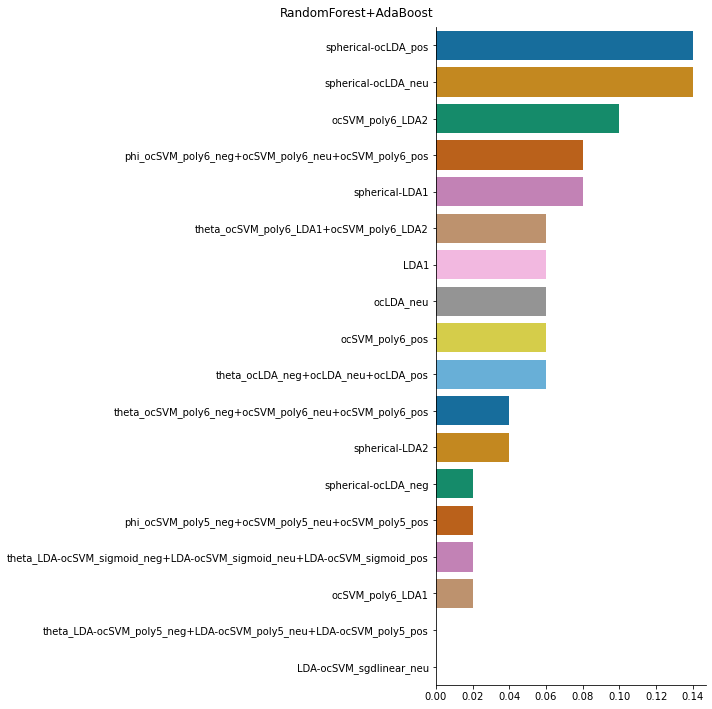

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


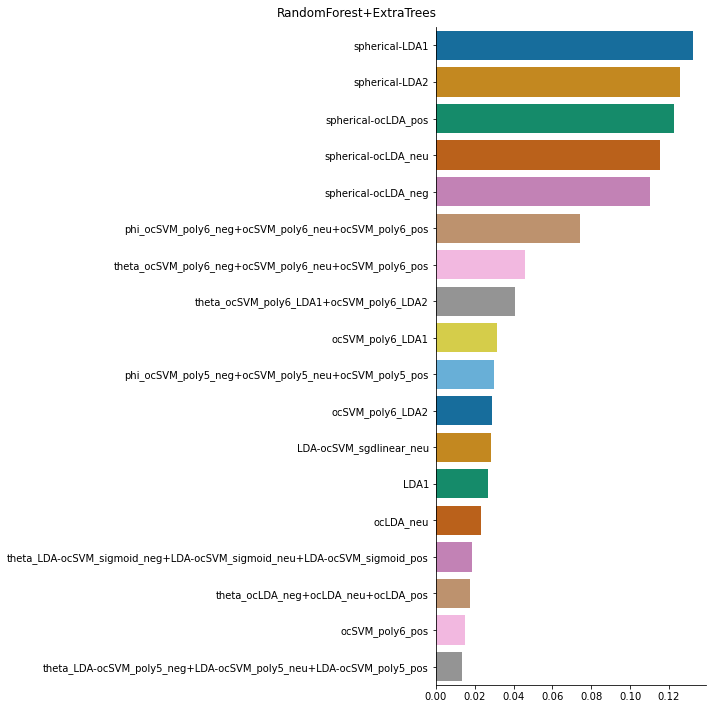

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


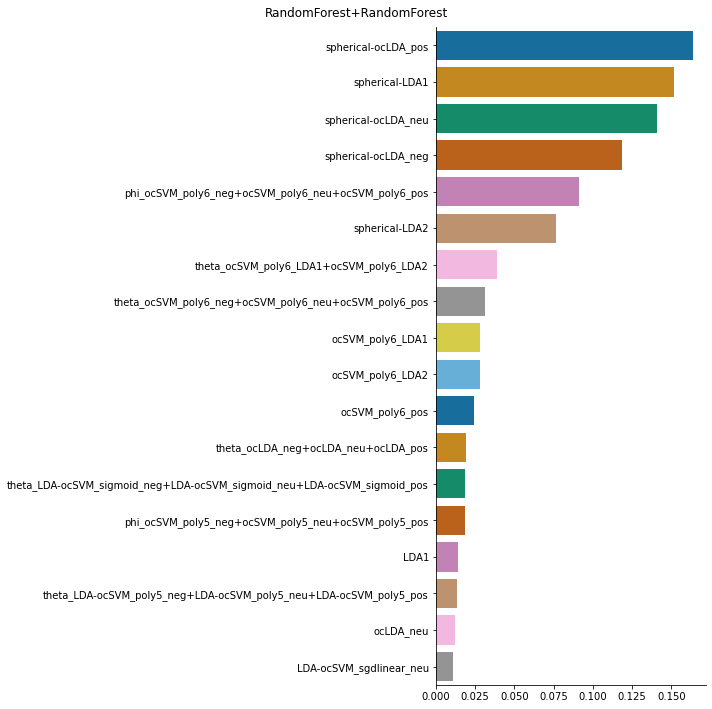

GaussianNB oob score changed by 0.0455 to 0.8283
extra trees oob score changed by -0.0097 to 0.9019
random forest oob score changed by -0.0147 to 0.9125

RandomForest+AdaBoost
accuracy: 0.8515
roc_auc_ovo: 0.8733
log_loss: 0.9721
RandomForest+ExtraTrees
accuracy: 0.9265
roc_auc_ovo: 0.9927
log_loss: 0.1920


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest+RandomForest
accuracy: 0.9695
roc_auc_ovo: 0.9986
log_loss: 0.1102
RandomForest+GaussianNB
accuracy: 0.8283
roc_auc_ovo: 0.9626
log_loss: 1.6883

with feature selection by RandomForest...
AdaBoost's accuracy changed by -0.0171 from 0.8686 to 0.8515
AdaBoost's roc_auc_ovo changed by -0.0329 from 0.9062 to 0.8733
AdaBoost's log_loss changed by -0.0236 from 0.9957 to 0.9721
ExtraTrees's accuracy changed by -0.0265 from 0.9530 to 0.9265
ExtraTrees's roc_auc_ovo changed by -0.0040 from 0.9967 to 0.9927
ExtraTrees's log_loss changed by 0.0161 from 0.1758 to 0.1920
RandomForest's accuracy changed by -0.0184 from 0.9879 to 0.9695
RandomForest's roc_auc_ovo changed by -0.0011 from 0.9997 to 0.9986
RandomForest's log_loss changed by 0.0253 from 0.0849 to 0.1102
GaussianNB's accuracy changed by 0.0455 from 0.7829 to 0.8283
GaussianNB's roc_auc_ovo changed by 0.0266 from 0.9360 to 0.9626
GaussianNB's log_loss changed by -2.7950 from 4.4833 to 1.6883

time: 2min 13s


In [15]:
data = load_data()
fitted_trees = fit_trees(data, y_true)
selectors = {
    model_name: SelectFromModel(estimator=fitted_model, prefit=True, max_features=18)
    for model_name, fitted_model in fitted_trees.items()
}
for selector_estimator, selector in selectors.items():
    print(f"selecting with {selector_estimator}")

    data_ = pd.DataFrame(
        selector.transform(data), columns=selector.get_feature_names_out(data.columns)
    )
    fitted_models: Dict[str, BaseEstimator] = {}

    for ensemble_name, fitted_tree in deepcopy(fitted_trees).items():
        fitted_models[
            f"{selector_estimator}+{ensemble_name}"
        ] = fitted_tree.fit(  # re-fit
            data_, y_true
        )
        plot_importances(
            fitted_tree, fig_height=10, title=f"{selector_estimator}+{ensemble_name}"
        )
    fitted_models[f"{selector_estimator}+GaussianNB"] = make_gnb().fit(data_, y_true)
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models[f'{selector_estimator}+GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_models[f'{selector_estimator}+ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_models[f'{selector_estimator}+RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()

    scores_after: Dict[str, Dict[str, float]] = {
        k: score_model(v, k, data=data_) for k, v in fitted_models.items()
    }

    print(f"\nwith feature selection by {selector_estimator}...")
    for after_model, after_score_dict in scores_before.items():
        after_scores: Dict[str, float] = scores_after[
            f"{selector_estimator}+{after_model}"
        ]
        before_scores: Dict[str, float] = scores_before[after_model]
        base_model = after_model.split("+")[-1]
        for scorer, score in after_scores.items():
            print(
                f"{base_model}'s {scorer} changed by {(after := after_scores[scorer]) - (before := before_scores[scorer]):.4f} from {before:.4f} to {after:.4f}"
            )
    print()

and with max 10

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


selecting with AdaBoost


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


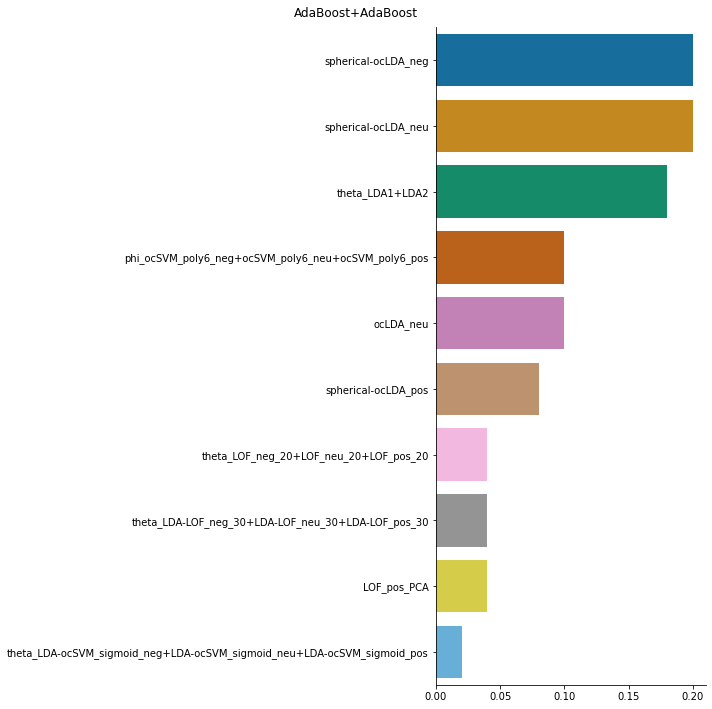

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


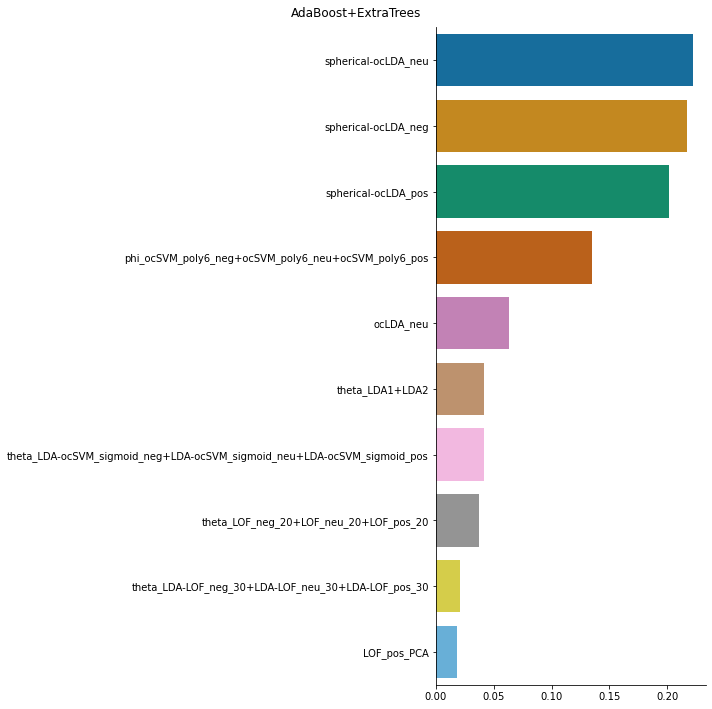

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


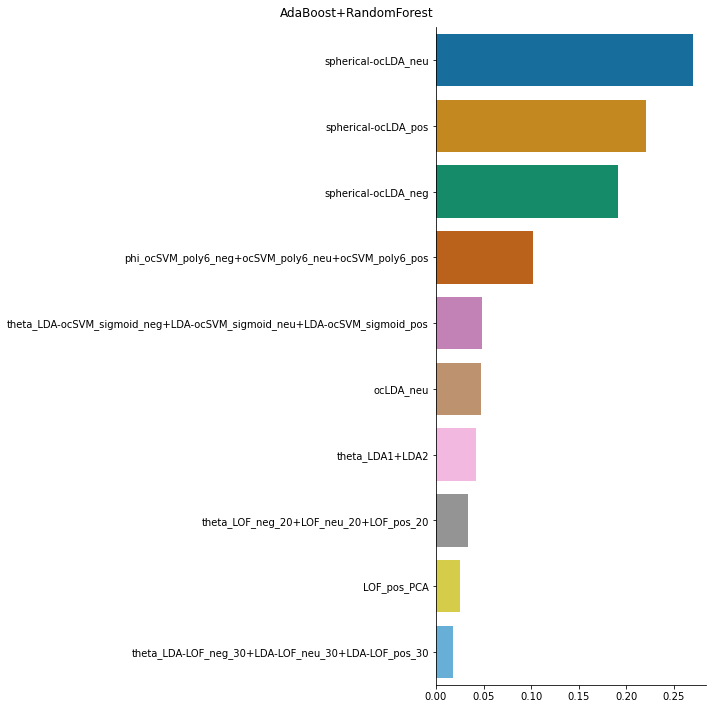

GaussianNB oob score changed by 0.0484 to 0.8312
extra trees oob score changed by -0.0115 to 0.9000
random forest oob score changed by -0.0158 to 0.9113

AdaBoost+AdaBoost
accuracy: 0.8837
roc_auc_ovo: 0.9640
log_loss: 1.0182
AdaBoost+ExtraTrees
accuracy: 0.9227
roc_auc_ovo: 0.9913
log_loss: 0.2076


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost+RandomForest
accuracy: 0.9710
roc_auc_ovo: 0.9986
log_loss: 0.1101
AdaBoost+GaussianNB
accuracy: 0.8311
roc_auc_ovo: 0.9635
log_loss: 0.8240

with feature selection by AdaBoost...
AdaBoost's accuracy changed by 0.0151 from 0.8686 to 0.8837
AdaBoost's roc_auc_ovo changed by 0.0578 from 0.9062 to 0.9640
AdaBoost's log_loss changed by 0.0225 from 0.9957 to 1.0182
ExtraTrees's accuracy changed by -0.0303 from 0.9530 to 0.9227
ExtraTrees's roc_auc_ovo changed by -0.0054 from 0.9967 to 0.9913
ExtraTrees's log_loss changed by 0.0318 from 0.1758 to 0.2076
RandomForest's accuracy changed by -0.0169 from 0.9879 to 0.9710
RandomForest's roc_auc_ovo changed by -0.0011 from 0.9997 to 0.9986
RandomForest's log_loss changed by 0.0252 from 0.0849 to 0.1101
GaussianNB's accuracy changed by 0.0482 from 0.7829 to 0.8311
GaussianNB's roc_auc_ovo changed by 0.0275 from 0.9360 to 0.9635
GaussianNB's log_loss changed by -3.6594 from 4.4833 to 0.8240

selecting with ExtraTrees


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


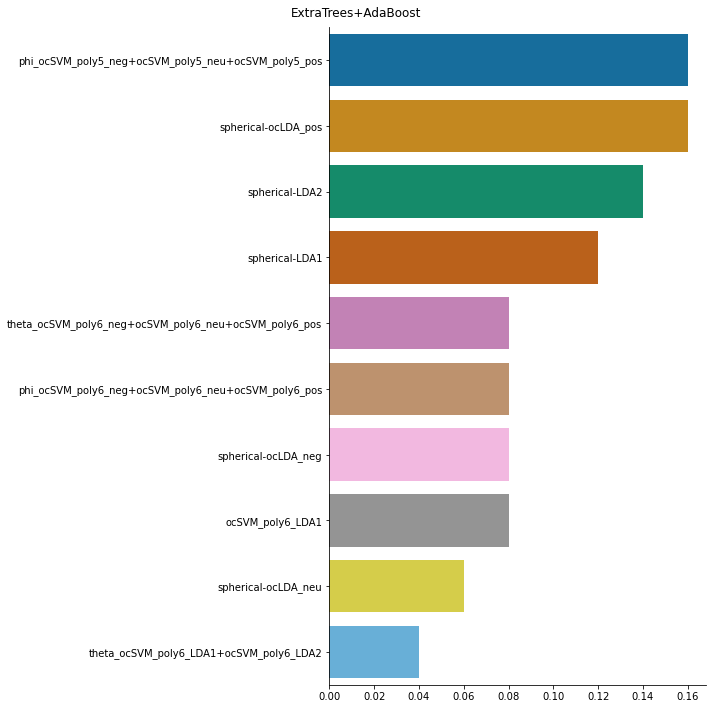

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


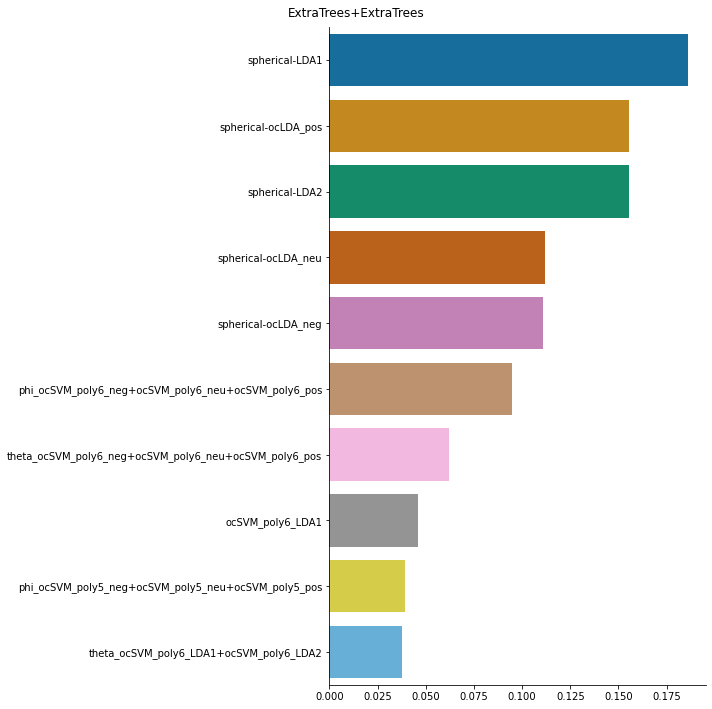

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


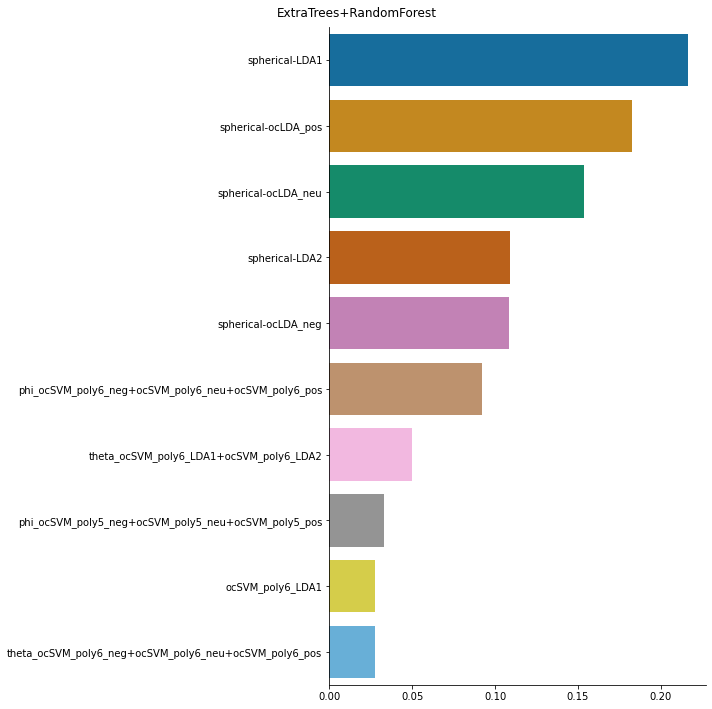

GaussianNB oob score changed by 0.0803 to 0.8630
extra trees oob score changed by -0.0180 to 0.8935
random forest oob score changed by -0.0275 to 0.8996

ExtraTrees+AdaBoost
accuracy: 0.8609
roc_auc_ovo: 0.8565
log_loss: 0.9743
ExtraTrees+ExtraTrees
accuracy: 0.9179
roc_auc_ovo: 0.9908
log_loss: 0.2044


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ExtraTrees+RandomForest
accuracy: 0.9598
roc_auc_ovo: 0.9975
log_loss: 0.1323
ExtraTrees+GaussianNB
accuracy: 0.8631
roc_auc_ovo: 0.9715
log_loss: 0.9777

with feature selection by ExtraTrees...
AdaBoost's accuracy changed by -0.0078 from 0.8686 to 0.8609
AdaBoost's roc_auc_ovo changed by -0.0496 from 0.9062 to 0.8565
AdaBoost's log_loss changed by -0.0214 from 0.9957 to 0.9743
ExtraTrees's accuracy changed by -0.0352 from 0.9530 to 0.9179
ExtraTrees's roc_auc_ovo changed by -0.0059 from 0.9967 to 0.9908
ExtraTrees's log_loss changed by 0.0286 from 0.1758 to 0.2044
RandomForest's accuracy changed by -0.0281 from 0.9879 to 0.9598
RandomForest's roc_auc_ovo changed by -0.0022 from 0.9997 to 0.9975
RandomForest's log_loss changed by 0.0474 from 0.0849 to 0.1323
GaussianNB's accuracy changed by 0.0803 from 0.7829 to 0.8631
GaussianNB's roc_auc_ovo changed by 0.0355 from 0.9360 to 0.9715
GaussianNB's log_loss changed by -3.5056 from 4.4833 to 0.9777

selecting with RandomForest


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


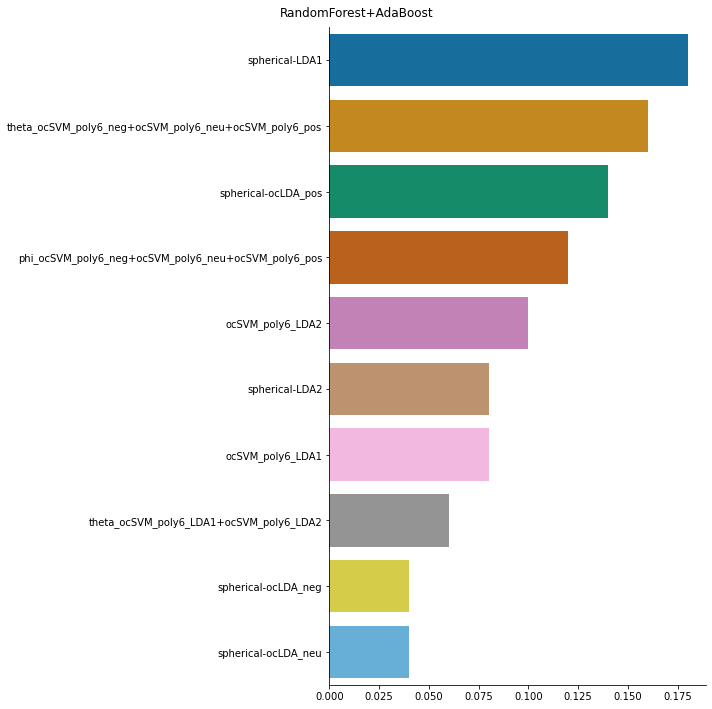

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


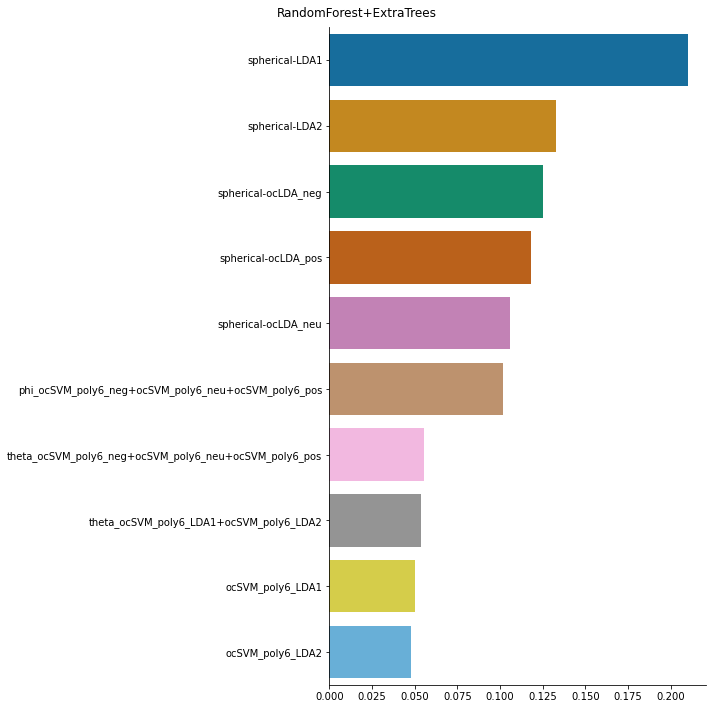

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


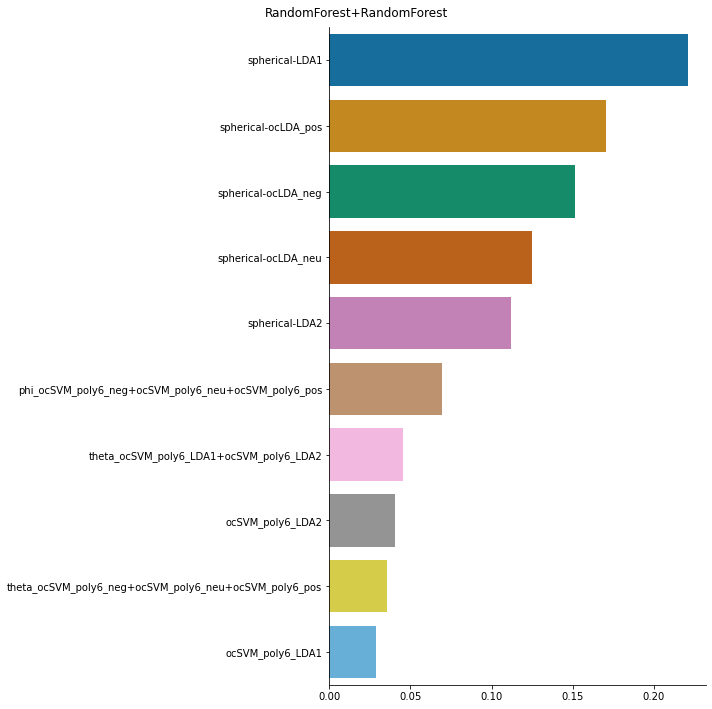

GaussianNB oob score changed by 0.0789 to 0.8617
extra trees oob score changed by -0.0207 to 0.8908
random forest oob score changed by -0.0317 to 0.8954

RandomForest+AdaBoost
accuracy: 0.8699
roc_auc_ovo: 0.8823
log_loss: 0.9596
RandomForest+ExtraTrees
accuracy: 0.9160
roc_auc_ovo: 0.9906
log_loss: 0.2056


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest+RandomForest
accuracy: 0.9575
roc_auc_ovo: 0.9973
log_loss: 0.1348
RandomForest+GaussianNB
accuracy: 0.8617
roc_auc_ovo: 0.9720
log_loss: 0.9928

with feature selection by RandomForest...
AdaBoost's accuracy changed by 0.0013 from 0.8686 to 0.8699
AdaBoost's roc_auc_ovo changed by -0.0238 from 0.9062 to 0.8823
AdaBoost's log_loss changed by -0.0361 from 0.9957 to 0.9596
ExtraTrees's accuracy changed by -0.0370 from 0.9530 to 0.9160
ExtraTrees's roc_auc_ovo changed by -0.0061 from 0.9967 to 0.9906
ExtraTrees's log_loss changed by 0.0298 from 0.1758 to 0.2056
RandomForest's accuracy changed by -0.0304 from 0.9879 to 0.9575
RandomForest's roc_auc_ovo changed by -0.0024 from 0.9997 to 0.9973
RandomForest's log_loss changed by 0.0499 from 0.0849 to 0.1348
GaussianNB's accuracy changed by 0.0788 from 0.7829 to 0.8617
GaussianNB's roc_auc_ovo changed by 0.0359 from 0.9360 to 0.9720
GaussianNB's log_loss changed by -3.4905 from 4.4833 to 0.9928

time: 2min 12s


In [16]:
data = load_data()
fitted_trees = fit_trees(data, y_true)
selectors = {
    model_name: SelectFromModel(estimator=fitted_model, prefit=True, max_features=10)
    for model_name, fitted_model in fitted_trees.items()
}
for selector_estimator, selector in selectors.items():
    print(f"selecting with {selector_estimator}")

    data_ = pd.DataFrame(
        selector.transform(data), columns=selector.get_feature_names_out(data.columns)
    )
    fitted_models: Dict[str, BaseEstimator] = {}

    for ensemble_name, fitted_tree in deepcopy(fitted_trees).items():
        fitted_models[
            f"{selector_estimator}+{ensemble_name}"
        ] = fitted_tree.fit(  # re-fit
            data_, y_true
        )
        plot_importances(
            fitted_tree, fig_height=10, title=f"{selector_estimator}+{ensemble_name}"
        )
    fitted_models[f"{selector_estimator}+GaussianNB"] = make_gnb().fit(data_, y_true)
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models[f'{selector_estimator}+GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_models[f'{selector_estimator}+ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_models[f'{selector_estimator}+RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()

    scores_after: Dict[str, Dict[str, float]] = {
        k: score_model(v, k, data=data_) for k, v in fitted_models.items()
    }

    print(f"\nwith feature selection by {selector_estimator}...")
    for after_model, after_score_dict in scores_before.items():
        after_scores: Dict[str, float] = scores_after[
            f"{selector_estimator}+{after_model}"
        ]
        before_scores: Dict[str, float] = scores_before[after_model]
        base_model = after_model.split("+")[-1]
        for scorer, score in after_scores.items():
            print(
                f"{base_model}'s {scorer} changed by {(after := after_scores[scorer]) - (before := before_scores[scorer]):.4f} from {before:.4f} to {after:.4f}"
            )
    print()

and with max 8

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


selecting with AdaBoost


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


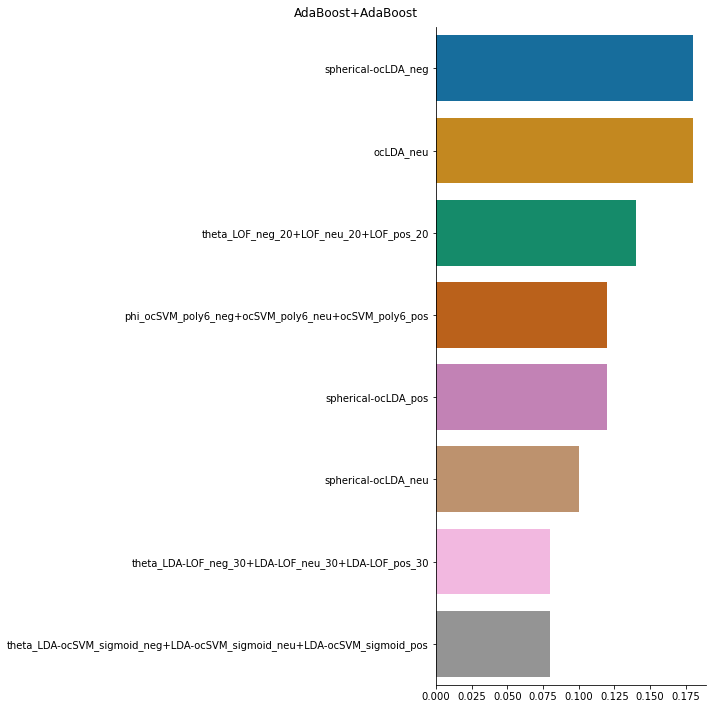

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


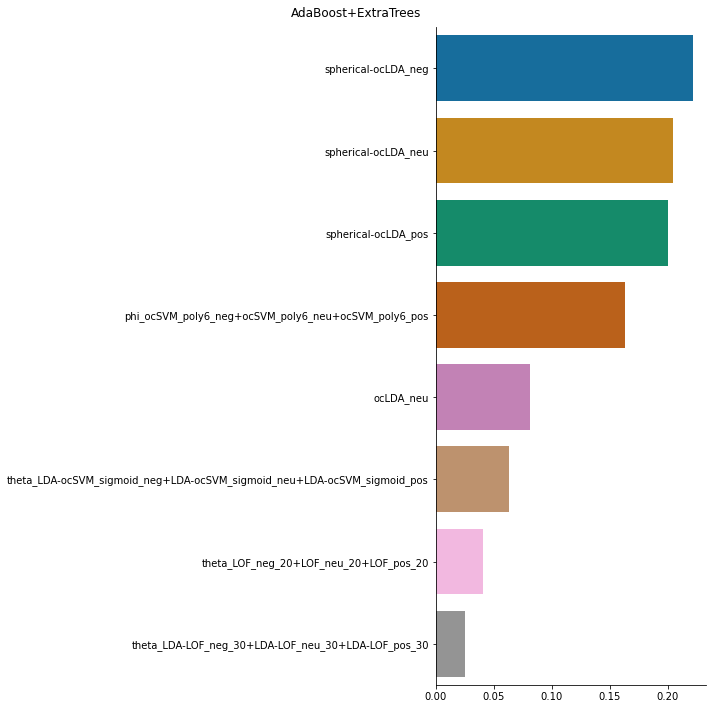

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


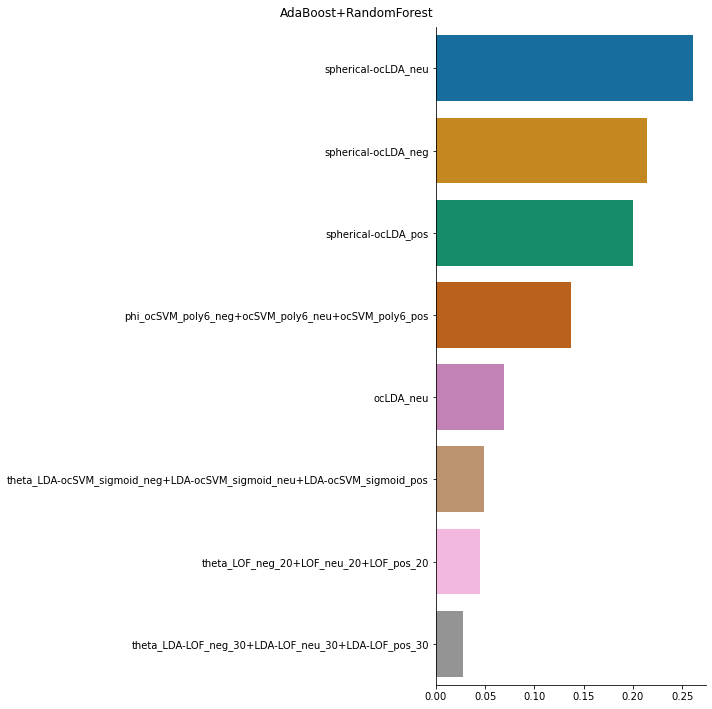

GaussianNB oob score changed by 0.0646 to 0.8473
extra trees oob score changed by -0.0186 to 0.8929
random forest oob score changed by -0.0201 to 0.9070

AdaBoost+AdaBoost
accuracy: 0.8566
roc_auc_ovo: 0.9447
log_loss: 1.0032
AdaBoost+ExtraTrees
accuracy: 0.9112
roc_auc_ovo: 0.9885
log_loss: 0.2340


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost+RandomForest
accuracy: 0.9644
roc_auc_ovo: 0.9979
log_loss: 0.1243
AdaBoost+GaussianNB
accuracy: 0.8474
roc_auc_ovo: 0.9670
log_loss: 0.6810

with feature selection by AdaBoost...
AdaBoost's accuracy changed by -0.0120 from 0.8686 to 0.8566
AdaBoost's roc_auc_ovo changed by 0.0385 from 0.9062 to 0.9447
AdaBoost's log_loss changed by 0.0075 from 0.9957 to 1.0032
ExtraTrees's accuracy changed by -0.0418 from 0.9530 to 0.9112
ExtraTrees's roc_auc_ovo changed by -0.0082 from 0.9967 to 0.9885
ExtraTrees's log_loss changed by 0.0581 from 0.1758 to 0.2340
RandomForest's accuracy changed by -0.0235 from 0.9879 to 0.9644
RandomForest's roc_auc_ovo changed by -0.0018 from 0.9997 to 0.9979
RandomForest's log_loss changed by 0.0394 from 0.0849 to 0.1243
GaussianNB's accuracy changed by 0.0645 from 0.7829 to 0.8474
GaussianNB's roc_auc_ovo changed by 0.0310 from 0.9360 to 0.9670
GaussianNB's log_loss changed by -3.8023 from 4.4833 to 0.6810

selecting with ExtraTrees


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


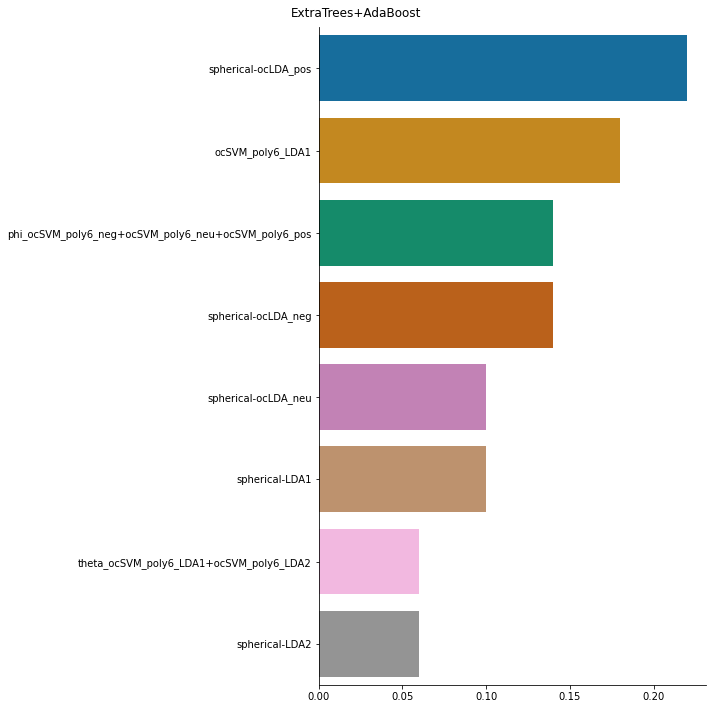

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


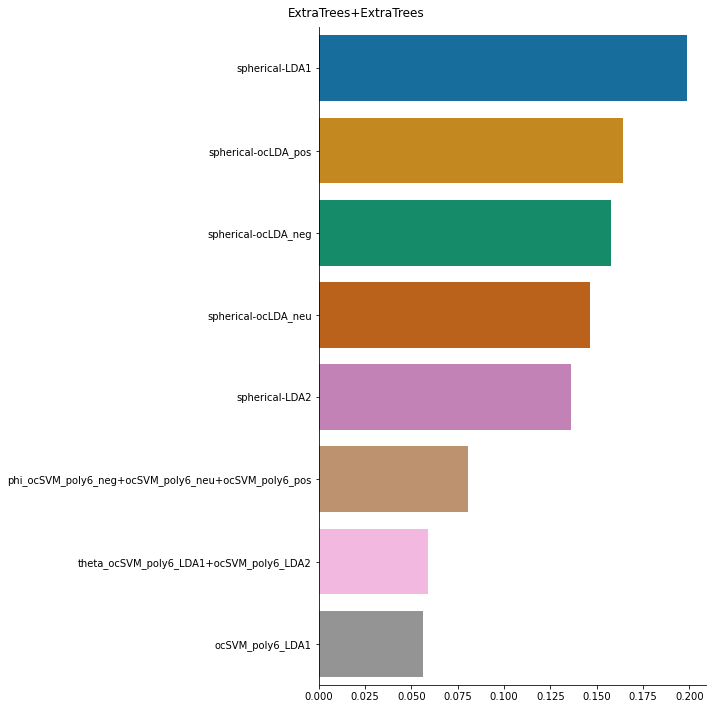

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


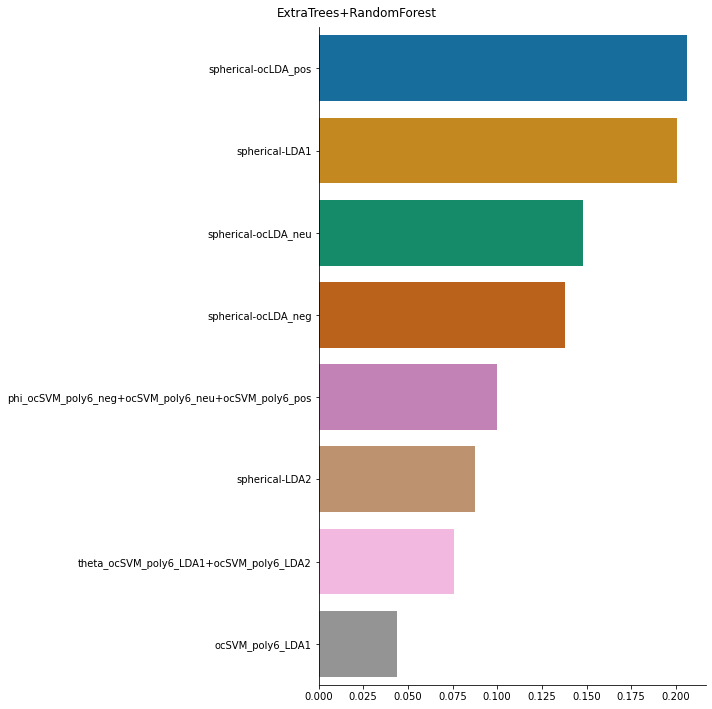

GaussianNB oob score changed by 0.0869 to 0.8696
extra trees oob score changed by -0.0253 to 0.8863
random forest oob score changed by -0.0350 to 0.8921

ExtraTrees+AdaBoost
accuracy: 0.8671
roc_auc_ovo: 0.8701
log_loss: 0.9738
ExtraTrees+ExtraTrees
accuracy: 0.9068
roc_auc_ovo: 0.9880
log_loss: 0.2271


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ExtraTrees+RandomForest
accuracy: 0.9514
roc_auc_ovo: 0.9966
log_loss: 0.1449
ExtraTrees+GaussianNB
accuracy: 0.8696
roc_auc_ovo: 0.9730
log_loss: 0.8363

with feature selection by ExtraTrees...
AdaBoost's accuracy changed by -0.0015 from 0.8686 to 0.8671
AdaBoost's roc_auc_ovo changed by -0.0361 from 0.9062 to 0.8701
AdaBoost's log_loss changed by -0.0218 from 0.9957 to 0.9738
ExtraTrees's accuracy changed by -0.0462 from 0.9530 to 0.9068
ExtraTrees's roc_auc_ovo changed by -0.0087 from 0.9967 to 0.9880
ExtraTrees's log_loss changed by 0.0512 from 0.1758 to 0.2271
RandomForest's accuracy changed by -0.0365 from 0.9879 to 0.9514
RandomForest's roc_auc_ovo changed by -0.0031 from 0.9997 to 0.9966
RandomForest's log_loss changed by 0.0600 from 0.0849 to 0.1449
GaussianNB's accuracy changed by 0.0868 from 0.7829 to 0.8696
GaussianNB's roc_auc_ovo changed by 0.0370 from 0.9360 to 0.9730
GaussianNB's log_loss changed by -3.6470 from 4.4833 to 0.8363

selecting with RandomForest


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


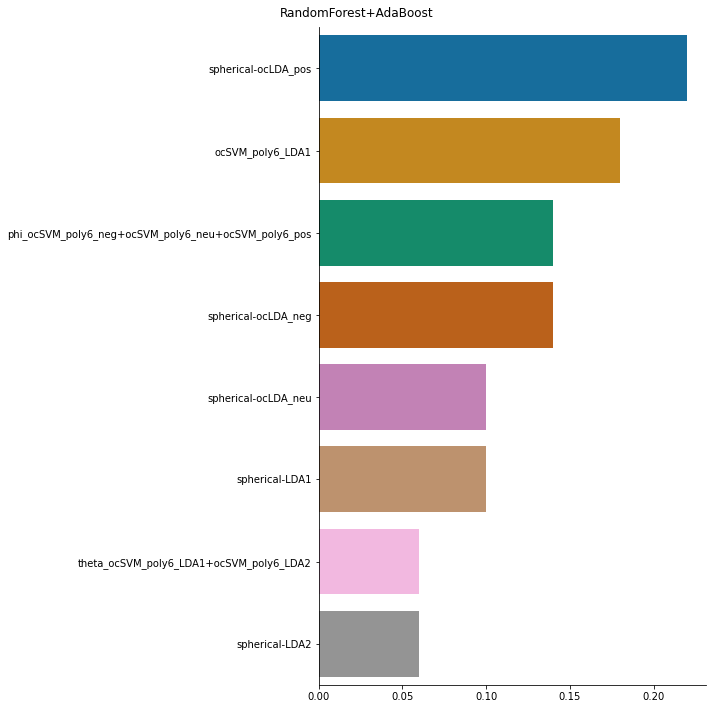

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


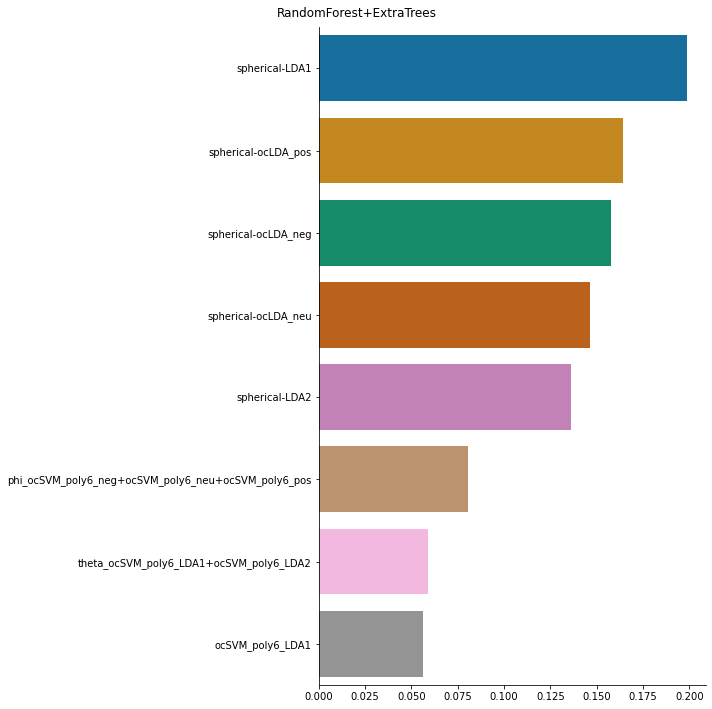

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


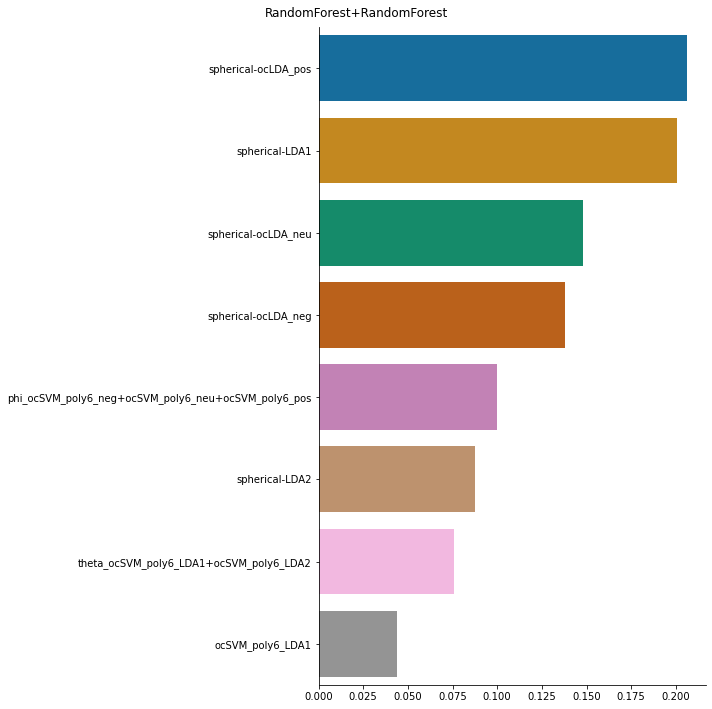

GaussianNB oob score changed by 0.0869 to 0.8696
extra trees oob score changed by -0.0253 to 0.8863
random forest oob score changed by -0.0350 to 0.8921

RandomForest+AdaBoost
accuracy: 0.8671
roc_auc_ovo: 0.8701
log_loss: 0.9738
RandomForest+ExtraTrees
accuracy: 0.9068
roc_auc_ovo: 0.9880
log_loss: 0.2271


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest+RandomForest
accuracy: 0.9514
roc_auc_ovo: 0.9966
log_loss: 0.1449
RandomForest+GaussianNB
accuracy: 0.8696
roc_auc_ovo: 0.9730
log_loss: 0.8363

with feature selection by RandomForest...
AdaBoost's accuracy changed by -0.0015 from 0.8686 to 0.8671
AdaBoost's roc_auc_ovo changed by -0.0361 from 0.9062 to 0.8701
AdaBoost's log_loss changed by -0.0218 from 0.9957 to 0.9738
ExtraTrees's accuracy changed by -0.0462 from 0.9530 to 0.9068
ExtraTrees's roc_auc_ovo changed by -0.0087 from 0.9967 to 0.9880
ExtraTrees's log_loss changed by 0.0512 from 0.1758 to 0.2271
RandomForest's accuracy changed by -0.0365 from 0.9879 to 0.9514
RandomForest's roc_auc_ovo changed by -0.0031 from 0.9997 to 0.9966
RandomForest's log_loss changed by 0.0600 from 0.0849 to 0.1449
GaussianNB's accuracy changed by 0.0868 from 0.7829 to 0.8696
GaussianNB's roc_auc_ovo changed by 0.0370 from 0.9360 to 0.9730
GaussianNB's log_loss changed by -3.6470 from 4.4833 to 0.8363

time: 2min 12s


In [17]:
data = load_data()
fitted_trees = fit_trees(data, y_true)
selectors = {
    model_name: SelectFromModel(estimator=fitted_model, prefit=True, max_features=8)
    for model_name, fitted_model in fitted_trees.items()
}
for selector_estimator, selector in selectors.items():
    print(f"selecting with {selector_estimator}")

    data_ = pd.DataFrame(
        selector.transform(data), columns=selector.get_feature_names_out(data.columns)
    )
    fitted_models: Dict[str, BaseEstimator] = {}

    for ensemble_name, fitted_tree in deepcopy(fitted_trees).items():
        fitted_models[
            f"{selector_estimator}+{ensemble_name}"
        ] = fitted_tree.fit(  # re-fit
            data_, y_true
        )
        plot_importances(
            fitted_tree, fig_height=10, title=f"{selector_estimator}+{ensemble_name}"
        )
    fitted_models[f"{selector_estimator}+GaussianNB"] = make_gnb().fit(data_, y_true)
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models[f'{selector_estimator}+GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_models[f'{selector_estimator}+ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_models[f'{selector_estimator}+RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()

    scores_after: Dict[str, Dict[str, float]] = {
        k: score_model(v, k, data=data_) for k, v in fitted_models.items()
    }

    print(f"\nwith feature selection by {selector_estimator}...")
    for after_model, after_score_dict in scores_before.items():
        after_scores: Dict[str, float] = scores_after[
            f"{selector_estimator}+{after_model}"
        ]
        before_scores: Dict[str, float] = scores_before[after_model]
        base_model = after_model.split("+")[-1]
        for scorer, score in after_scores.items():
            print(
                f"{base_model}'s {scorer} changed by {(after := after_scores[scorer]) - (before := before_scores[scorer]):.4f} from {before:.4f} to {after:.4f}"
            )
    print()

with SelectKBest

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


selecting with SelectKBest_1


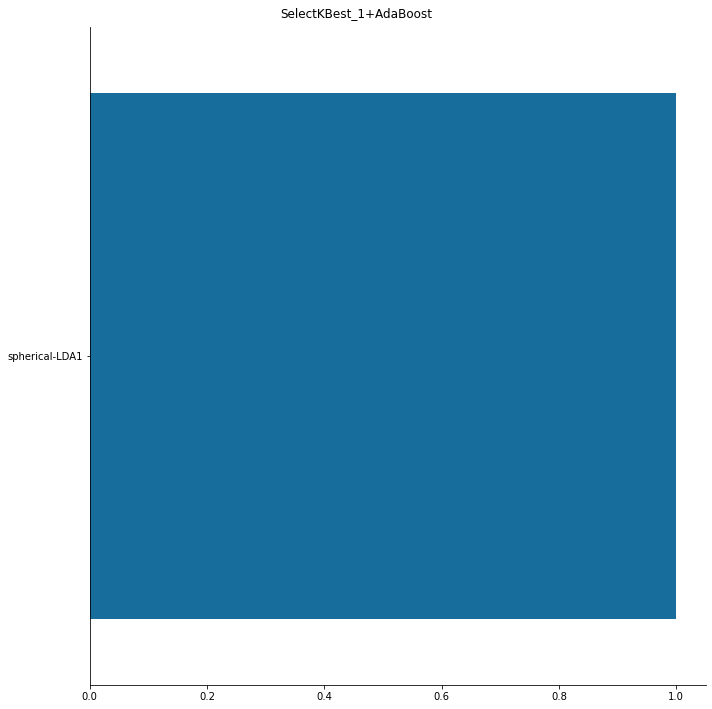

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


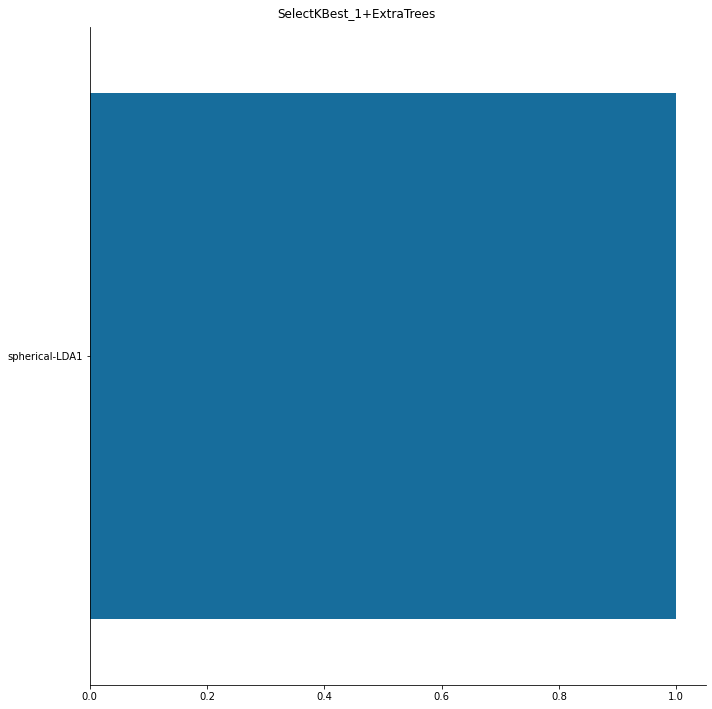

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


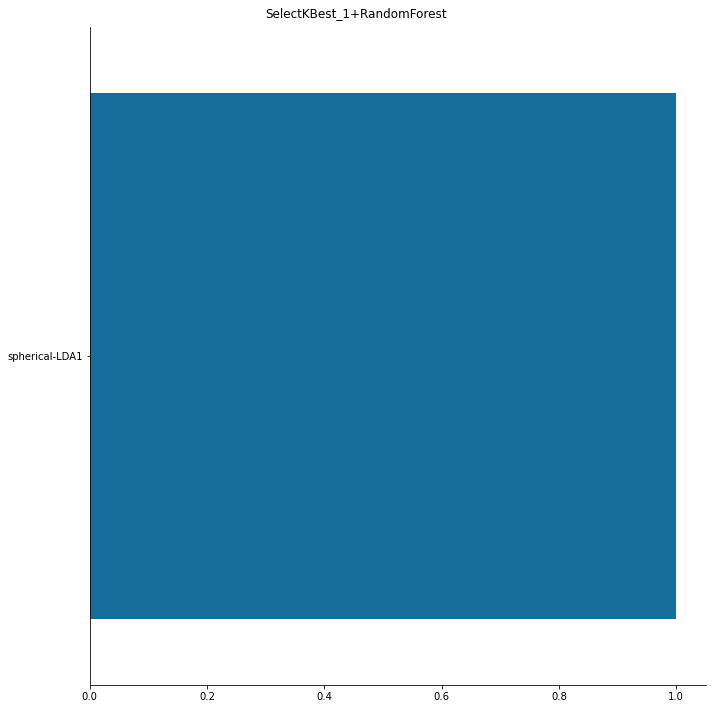

GaussianNB oob score changed by 0.0226 to 0.8054
extra trees oob score changed by -0.1178 to 0.7938
random forest oob score changed by -0.1338 to 0.7933

SelectKBest_1+AdaBoost
accuracy: 0.7963
roc_auc_ovo: 0.8219
log_loss: 0.9952
SelectKBest_1+ExtraTrees
accuracy: 0.8209
roc_auc_ovo: 0.9494
log_loss: 0.4404


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_1+RandomForest
accuracy: 0.8221
roc_auc_ovo: 0.9455
log_loss: 0.4398
SelectKBest_1+GaussianNB
accuracy: 0.8054
roc_auc_ovo: 0.9021
log_loss: 0.5356

with feature selection by SelectKBest_1...
AdaBoost's accuracy changed by -0.0723 from 0.8686 to 0.7963
AdaBoost's roc_auc_ovo changed by -0.0842 from 0.9062 to 0.8219
AdaBoost's log_loss changed by -0.0005 from 0.9957 to 0.9952
ExtraTrees's accuracy changed by -0.1321 from 0.9530 to 0.8209
ExtraTrees's roc_auc_ovo changed by -0.0474 from 0.9967 to 0.9494
ExtraTrees's log_loss changed by 0.2646 from 0.1758 to 0.4404
RandomForest's accuracy changed by -0.1658 from 0.9879 to 0.8221
RandomForest's roc_auc_ovo changed by -0.0542 from 0.9997 to 0.9455
RandomForest's log_loss changed by 0.3549 from 0.0849 to 0.4398
GaussianNB's accuracy changed by 0.0226 from 0.7829 to 0.8054
GaussianNB's roc_auc_ovo changed by -0.0339 from 0.9360 to 0.9021
GaussianNB's log_loss changed by -3.9477 from 4.4833 to 0.5356

selecting with SelectKBest_2


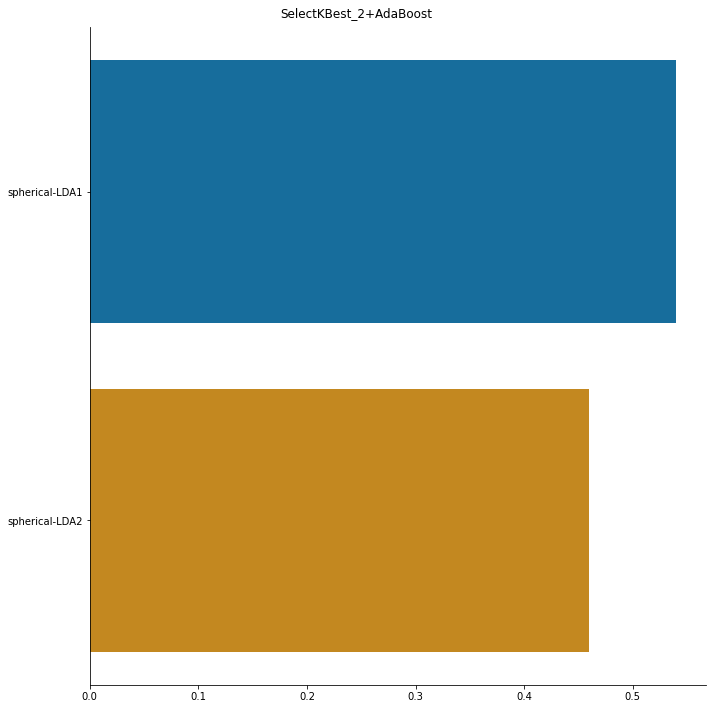

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


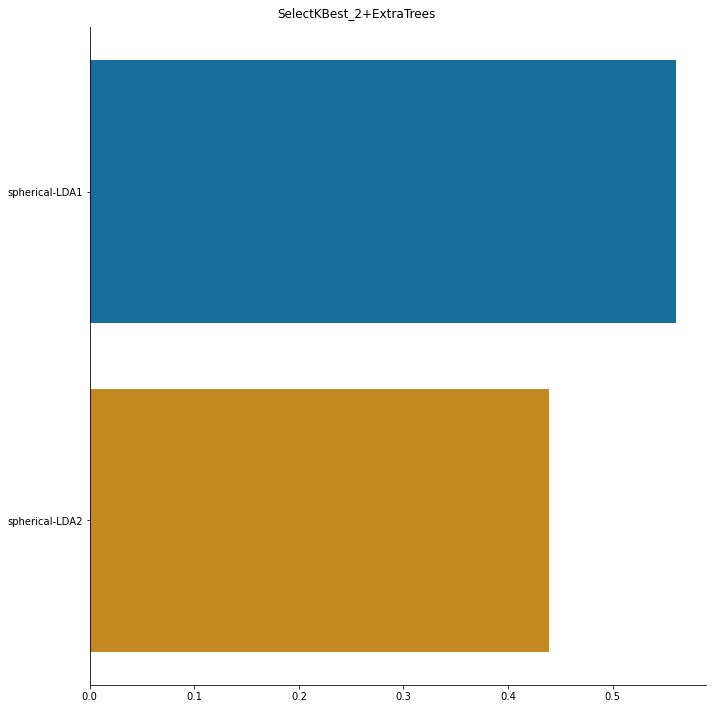

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


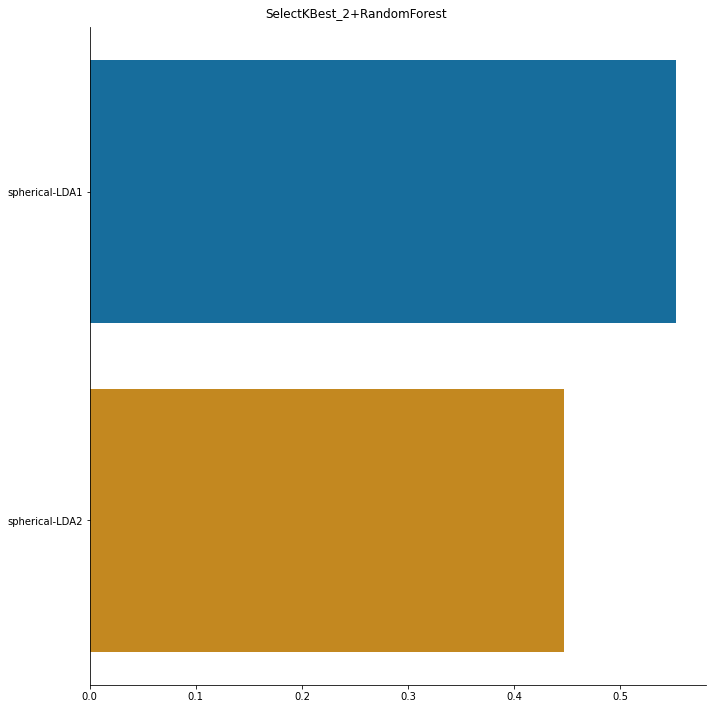

GaussianNB oob score changed by 0.0930 to 0.8757
extra trees oob score changed by -0.0362 to 0.8754
random forest oob score changed by -0.0509 to 0.8762

SelectKBest_2+AdaBoost
accuracy: 0.8644
roc_auc_ovo: 0.8669
log_loss: 0.9546
SelectKBest_2+ExtraTrees
accuracy: 0.8948
roc_auc_ovo: 0.9836
log_loss: 0.2596


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_2+RandomForest
accuracy: 0.9209
roc_auc_ovo: 0.9916
log_loss: 0.1933
SelectKBest_2+GaussianNB
accuracy: 0.8756
roc_auc_ovo: 0.9704
log_loss: 0.3578

with feature selection by SelectKBest_2...
AdaBoost's accuracy changed by -0.0042 from 0.8686 to 0.8644
AdaBoost's roc_auc_ovo changed by -0.0393 from 0.9062 to 0.8669
AdaBoost's log_loss changed by -0.0411 from 0.9957 to 0.9546
ExtraTrees's accuracy changed by -0.0582 from 0.9530 to 0.8948
ExtraTrees's roc_auc_ovo changed by -0.0131 from 0.9967 to 0.9836
ExtraTrees's log_loss changed by 0.0838 from 0.1758 to 0.2596
RandomForest's accuracy changed by -0.0670 from 0.9879 to 0.9209
RandomForest's roc_auc_ovo changed by -0.0081 from 0.9997 to 0.9916
RandomForest's log_loss changed by 0.1084 from 0.0849 to 0.1933
GaussianNB's accuracy changed by 0.0928 from 0.7829 to 0.8756
GaussianNB's roc_auc_ovo changed by 0.0343 from 0.9360 to 0.9704
GaussianNB's log_loss changed by -4.1256 from 4.4833 to 0.3578

selecting with SelectKBest_3


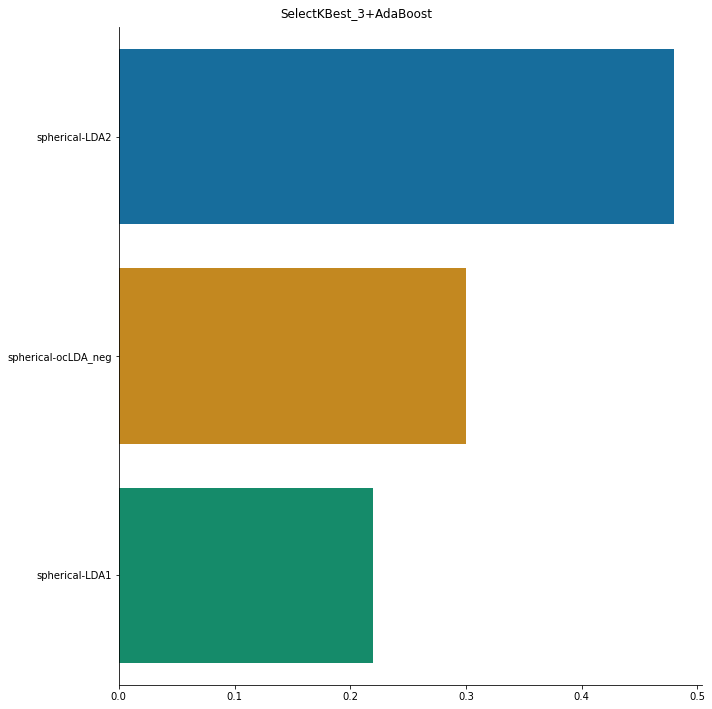

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


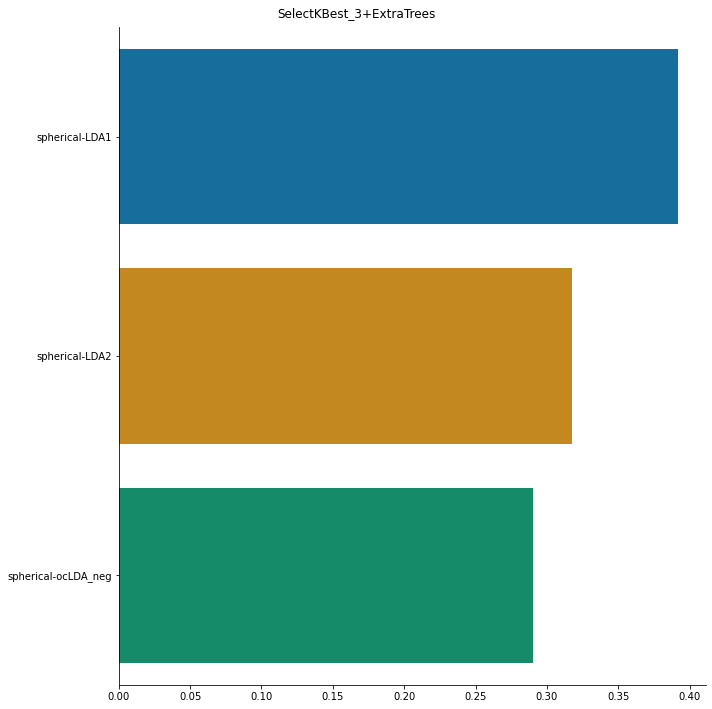

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


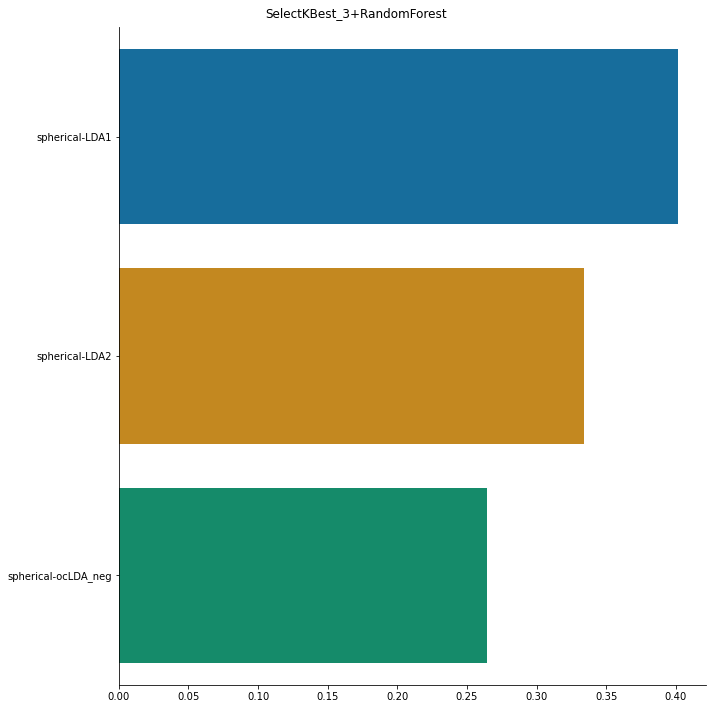

GaussianNB oob score changed by 0.0922 to 0.8750
extra trees oob score changed by -0.0347 to 0.8768
random forest oob score changed by -0.0508 to 0.8763

SelectKBest_3+AdaBoost
accuracy: 0.8609
roc_auc_ovo: 0.9161
log_loss: 0.9577
SelectKBest_3+ExtraTrees
accuracy: 0.8914
roc_auc_ovo: 0.9823
log_loss: 0.2669


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_3+RandomForest
accuracy: 0.9244
roc_auc_ovo: 0.9924
log_loss: 0.1861
SelectKBest_3+GaussianNB
accuracy: 0.8750
roc_auc_ovo: 0.9674
log_loss: 0.4670

with feature selection by SelectKBest_3...
AdaBoost's accuracy changed by -0.0077 from 0.8686 to 0.8609
AdaBoost's roc_auc_ovo changed by 0.0100 from 0.9062 to 0.9161
AdaBoost's log_loss changed by -0.0380 from 0.9957 to 0.9577
ExtraTrees's accuracy changed by -0.0616 from 0.9530 to 0.8914
ExtraTrees's roc_auc_ovo changed by -0.0144 from 0.9967 to 0.9823
ExtraTrees's log_loss changed by 0.0911 from 0.1758 to 0.2669
RandomForest's accuracy changed by -0.0635 from 0.9879 to 0.9244
RandomForest's roc_auc_ovo changed by -0.0073 from 0.9997 to 0.9924
RandomForest's log_loss changed by 0.1012 from 0.0849 to 0.1861
GaussianNB's accuracy changed by 0.0921 from 0.7829 to 0.8750
GaussianNB's roc_auc_ovo changed by 0.0314 from 0.9360 to 0.9674
GaussianNB's log_loss changed by -4.0163 from 4.4833 to 0.4670

selecting with SelectKBest_4


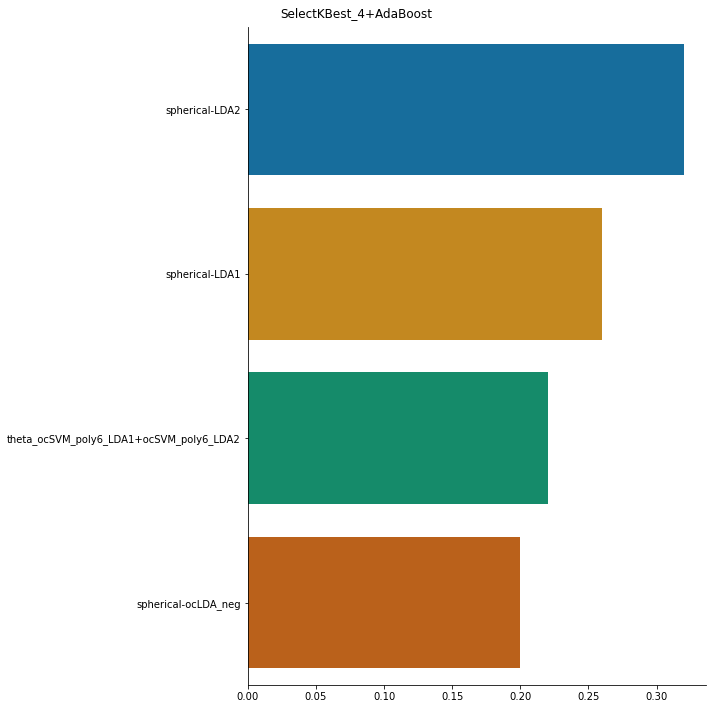

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


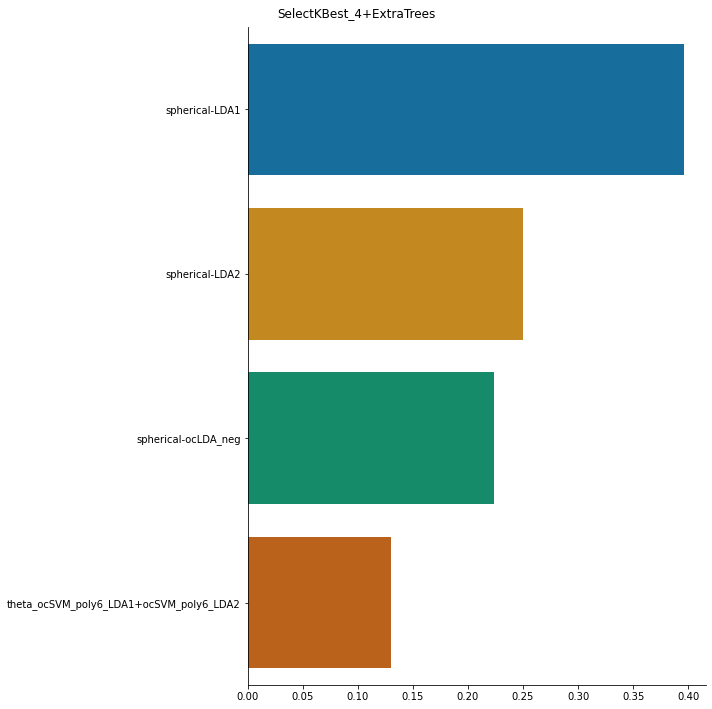

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


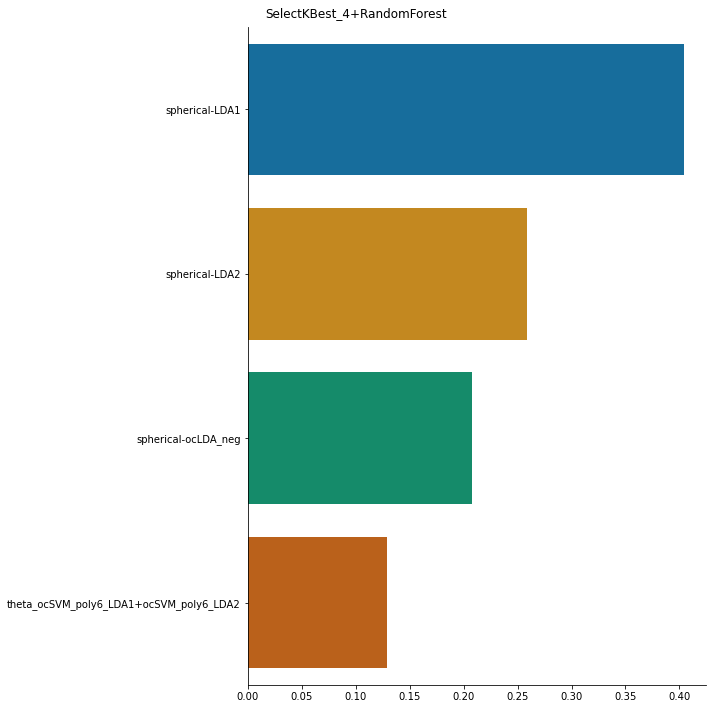

GaussianNB oob score changed by 0.0886 to 0.8713
extra trees oob score changed by -0.0304 to 0.8811
random forest oob score changed by -0.0437 to 0.8834

SelectKBest_4+AdaBoost
accuracy: 0.8711
roc_auc_ovo: 0.8777
log_loss: 0.9477
SelectKBest_4+ExtraTrees
accuracy: 0.9059
roc_auc_ovo: 0.9877
log_loss: 0.2276


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_4+RandomForest
accuracy: 0.9405
roc_auc_ovo: 0.9954
log_loss: 0.1578
SelectKBest_4+GaussianNB
accuracy: 0.8713
roc_auc_ovo: 0.9685
log_loss: 0.5323

with feature selection by SelectKBest_4...
AdaBoost's accuracy changed by 0.0025 from 0.8686 to 0.8711
AdaBoost's roc_auc_ovo changed by -0.0284 from 0.9062 to 0.8777
AdaBoost's log_loss changed by -0.0479 from 0.9957 to 0.9477
ExtraTrees's accuracy changed by -0.0471 from 0.9530 to 0.9059
ExtraTrees's roc_auc_ovo changed by -0.0090 from 0.9967 to 0.9877
ExtraTrees's log_loss changed by 0.0517 from 0.1758 to 0.2276
RandomForest's accuracy changed by -0.0474 from 0.9879 to 0.9405
RandomForest's roc_auc_ovo changed by -0.0044 from 0.9997 to 0.9954
RandomForest's log_loss changed by 0.0729 from 0.0849 to 0.1578
GaussianNB's accuracy changed by 0.0885 from 0.7829 to 0.8713
GaussianNB's roc_auc_ovo changed by 0.0325 from 0.9360 to 0.9685
GaussianNB's log_loss changed by -3.9511 from 4.4833 to 0.5323

selecting with SelectKBest_5


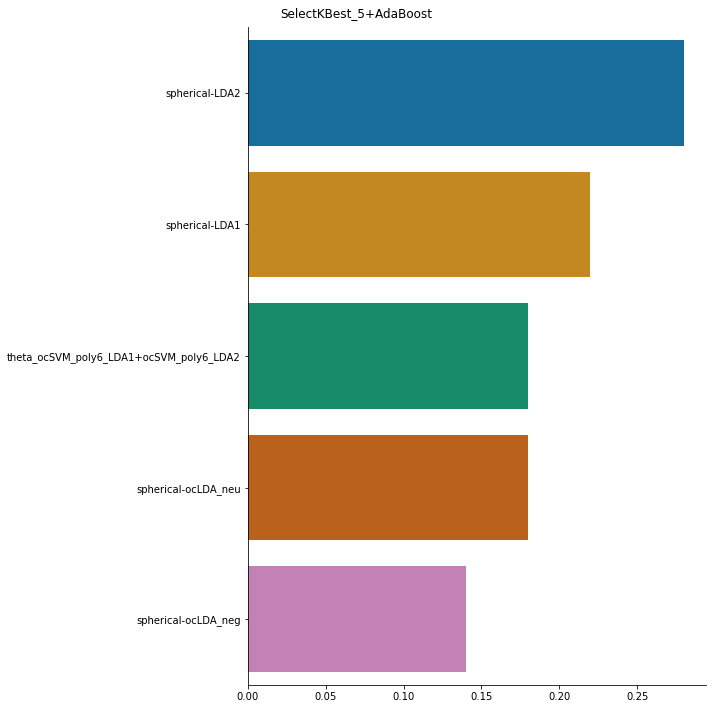

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


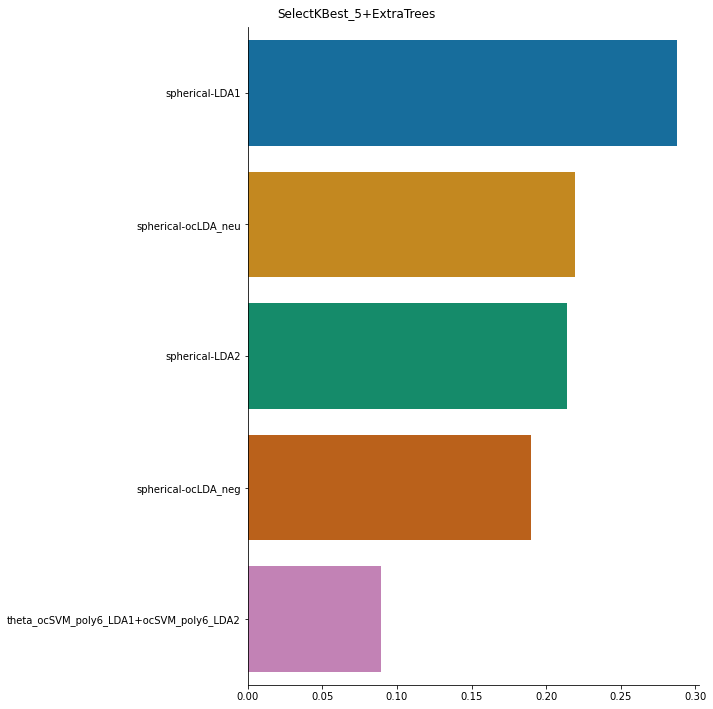

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


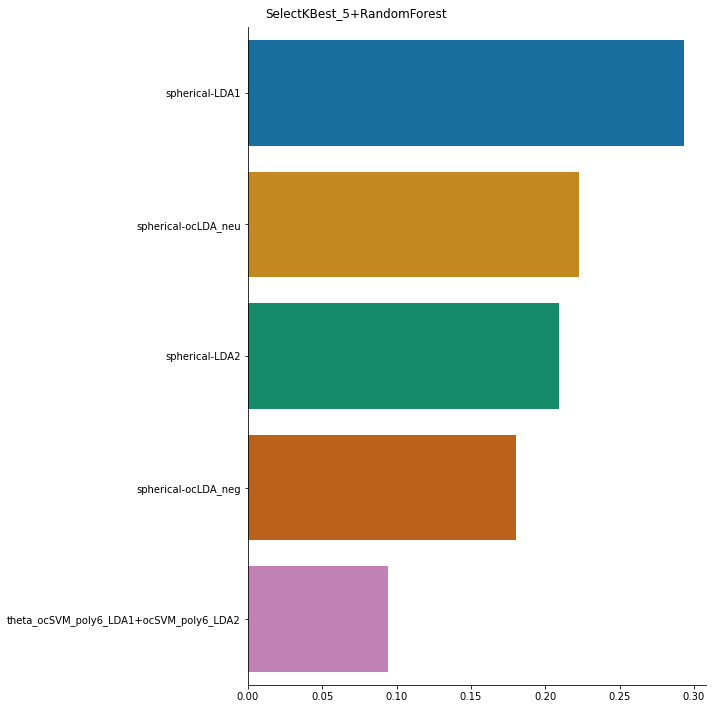

GaussianNB oob score changed by 0.0855 to 0.8682
extra trees oob score changed by -0.0311 to 0.8805
random forest oob score changed by -0.0441 to 0.8830

SelectKBest_5+AdaBoost
accuracy: 0.8670
roc_auc_ovo: 0.8924
log_loss: 0.9543
SelectKBest_5+ExtraTrees
accuracy: 0.9029
roc_auc_ovo: 0.9870
log_loss: 0.2324


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_5+RandomForest
accuracy: 0.9389
roc_auc_ovo: 0.9952
log_loss: 0.1604
SelectKBest_5+GaussianNB
accuracy: 0.8683
roc_auc_ovo: 0.9694
log_loss: 0.6214

with feature selection by SelectKBest_5...
AdaBoost's accuracy changed by -0.0016 from 0.8686 to 0.8670
AdaBoost's roc_auc_ovo changed by -0.0138 from 0.9062 to 0.8924
AdaBoost's log_loss changed by -0.0413 from 0.9957 to 0.9543
ExtraTrees's accuracy changed by -0.0501 from 0.9530 to 0.9029
ExtraTrees's roc_auc_ovo changed by -0.0097 from 0.9967 to 0.9870
ExtraTrees's log_loss changed by 0.0566 from 0.1758 to 0.2324
RandomForest's accuracy changed by -0.0490 from 0.9879 to 0.9389
RandomForest's roc_auc_ovo changed by -0.0045 from 0.9997 to 0.9952
RandomForest's log_loss changed by 0.0755 from 0.0849 to 0.1604
GaussianNB's accuracy changed by 0.0854 from 0.7829 to 0.8683
GaussianNB's roc_auc_ovo changed by 0.0333 from 0.9360 to 0.9694
GaussianNB's log_loss changed by -3.8619 from 4.4833 to 0.6214

selecting with SelectKBest_6


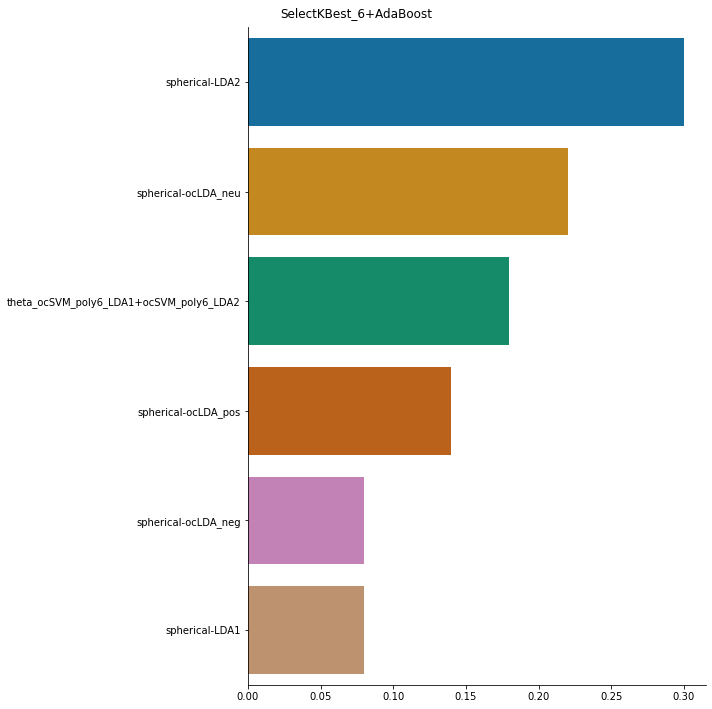

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


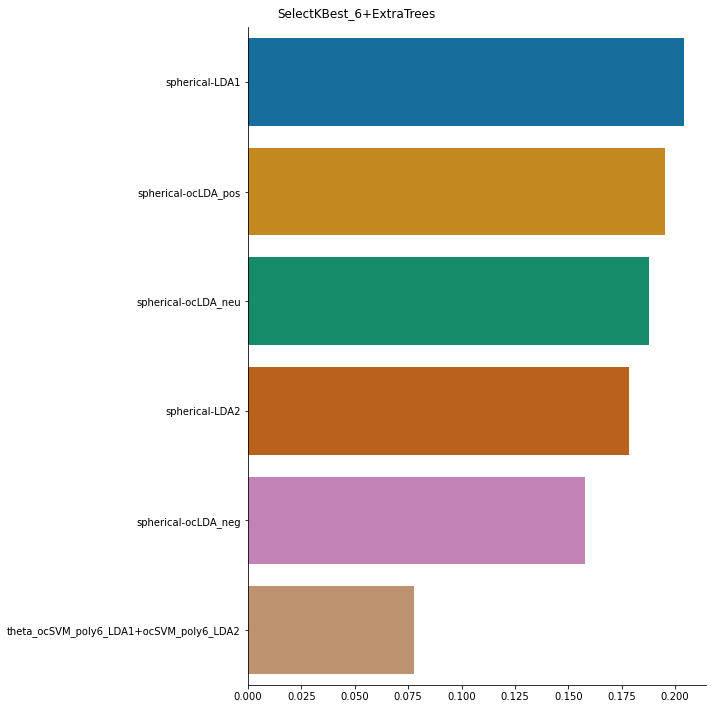

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


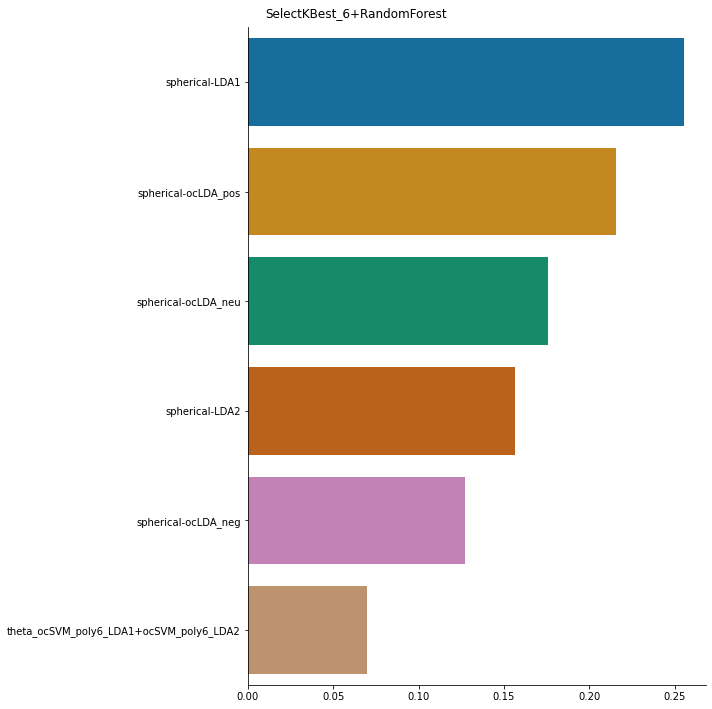

GaussianNB oob score changed by 0.0848 to 0.8676
extra trees oob score changed by -0.0311 to 0.8805
random forest oob score changed by -0.0436 to 0.8836

SelectKBest_6+AdaBoost
accuracy: 0.8568
roc_auc_ovo: 0.8841
log_loss: 0.9871
SelectKBest_6+ExtraTrees
accuracy: 0.9033
roc_auc_ovo: 0.9870
log_loss: 0.2317


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_6+RandomForest
accuracy: 0.9387
roc_auc_ovo: 0.9952
log_loss: 0.1613
SelectKBest_6+GaussianNB
accuracy: 0.8677
roc_auc_ovo: 0.9726
log_loss: 0.7083

with feature selection by SelectKBest_6...
AdaBoost's accuracy changed by -0.0118 from 0.8686 to 0.8568
AdaBoost's roc_auc_ovo changed by -0.0221 from 0.9062 to 0.8841
AdaBoost's log_loss changed by -0.0085 from 0.9957 to 0.9871
ExtraTrees's accuracy changed by -0.0497 from 0.9530 to 0.9033
ExtraTrees's roc_auc_ovo changed by -0.0097 from 0.9967 to 0.9870
ExtraTrees's log_loss changed by 0.0559 from 0.1758 to 0.2317
RandomForest's accuracy changed by -0.0492 from 0.9879 to 0.9387
RandomForest's roc_auc_ovo changed by -0.0046 from 0.9997 to 0.9952
RandomForest's log_loss changed by 0.0764 from 0.0849 to 0.1613
GaussianNB's accuracy changed by 0.0848 from 0.7829 to 0.8677
GaussianNB's roc_auc_ovo changed by 0.0366 from 0.9360 to 0.9726
GaussianNB's log_loss changed by -3.7751 from 4.4833 to 0.7083

selecting with SelectKBest_7


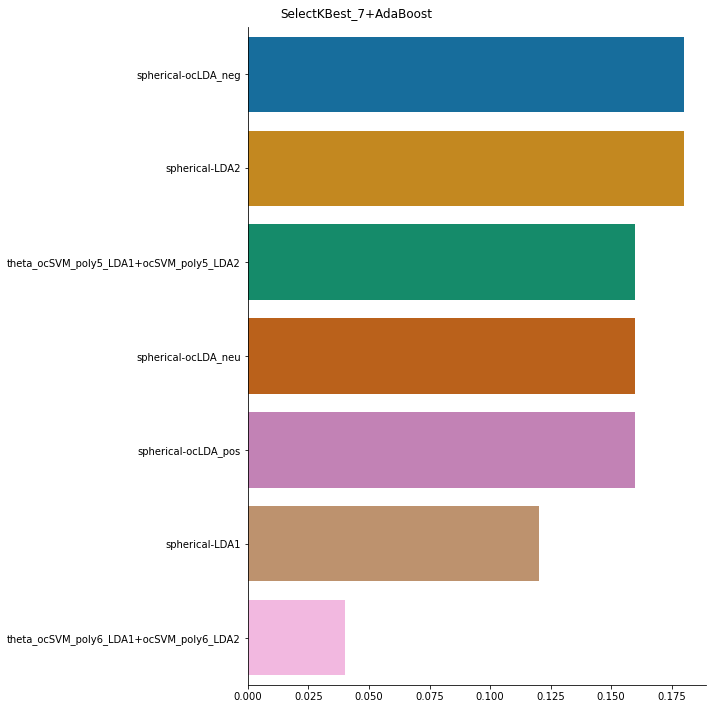

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


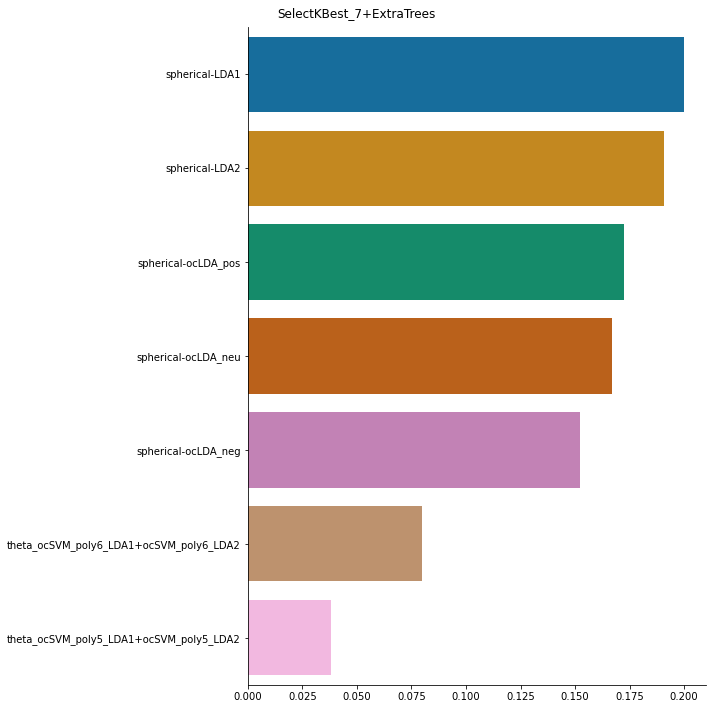

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


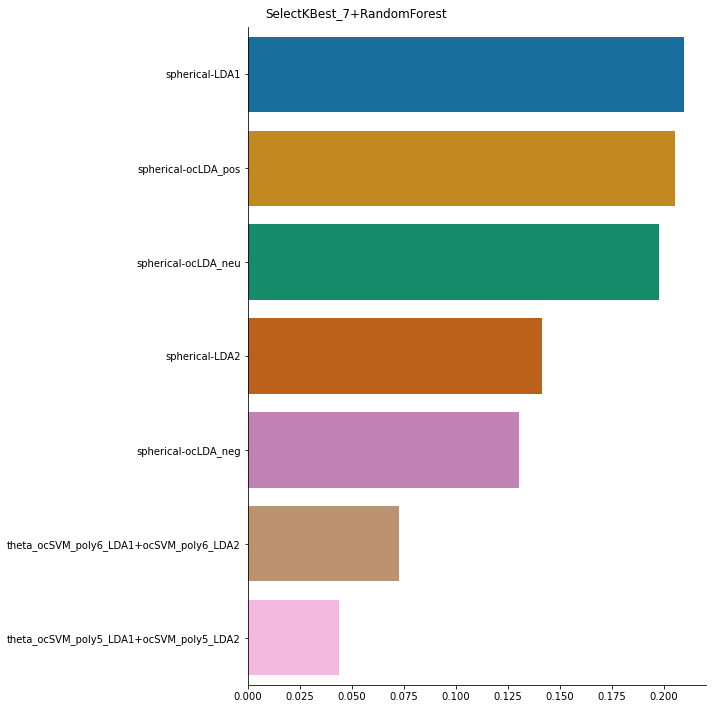

GaussianNB oob score changed by 0.0806 to 0.8634
extra trees oob score changed by -0.0281 to 0.8834
random forest oob score changed by -0.0374 to 0.8897

SelectKBest_7+AdaBoost
accuracy: 0.8554
roc_auc_ovo: 0.8863
log_loss: 0.9844
SelectKBest_7+ExtraTrees
accuracy: 0.9051
roc_auc_ovo: 0.9871
log_loss: 0.2325


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_7+RandomForest
accuracy: 0.9468
roc_auc_ovo: 0.9963
log_loss: 0.1497
SelectKBest_7+GaussianNB
accuracy: 0.8634
roc_auc_ovo: 0.9717
log_loss: 0.7659

with feature selection by SelectKBest_7...
AdaBoost's accuracy changed by -0.0132 from 0.8686 to 0.8554
AdaBoost's roc_auc_ovo changed by -0.0199 from 0.9062 to 0.8863
AdaBoost's log_loss changed by -0.0113 from 0.9957 to 0.9844
ExtraTrees's accuracy changed by -0.0479 from 0.9530 to 0.9051
ExtraTrees's roc_auc_ovo changed by -0.0096 from 0.9967 to 0.9871
ExtraTrees's log_loss changed by 0.0567 from 0.1758 to 0.2325
RandomForest's accuracy changed by -0.0411 from 0.9879 to 0.9468
RandomForest's roc_auc_ovo changed by -0.0035 from 0.9997 to 0.9963
RandomForest's log_loss changed by 0.0648 from 0.0849 to 0.1497
GaussianNB's accuracy changed by 0.0806 from 0.7829 to 0.8634
GaussianNB's roc_auc_ovo changed by 0.0357 from 0.9360 to 0.9717
GaussianNB's log_loss changed by -3.7174 from 4.4833 to 0.7659

selecting with SelectKBest_8


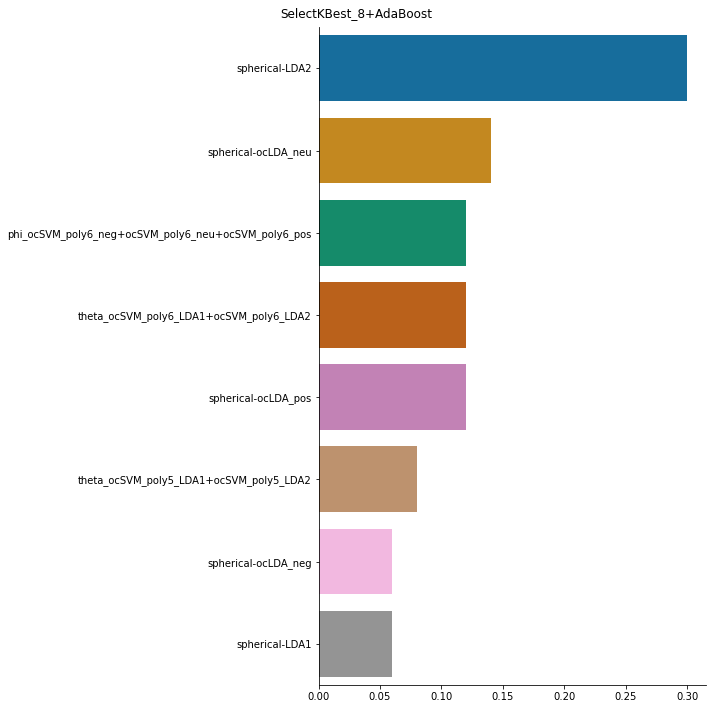

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


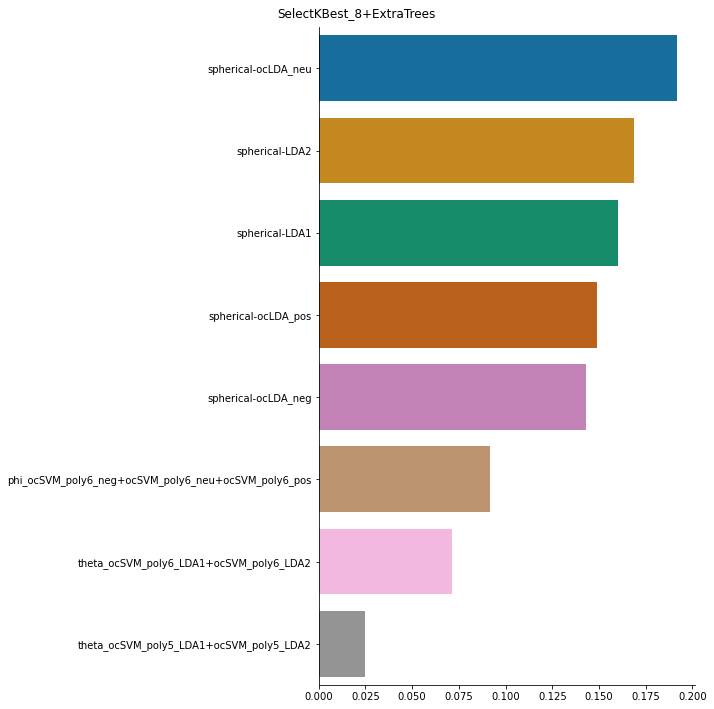

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


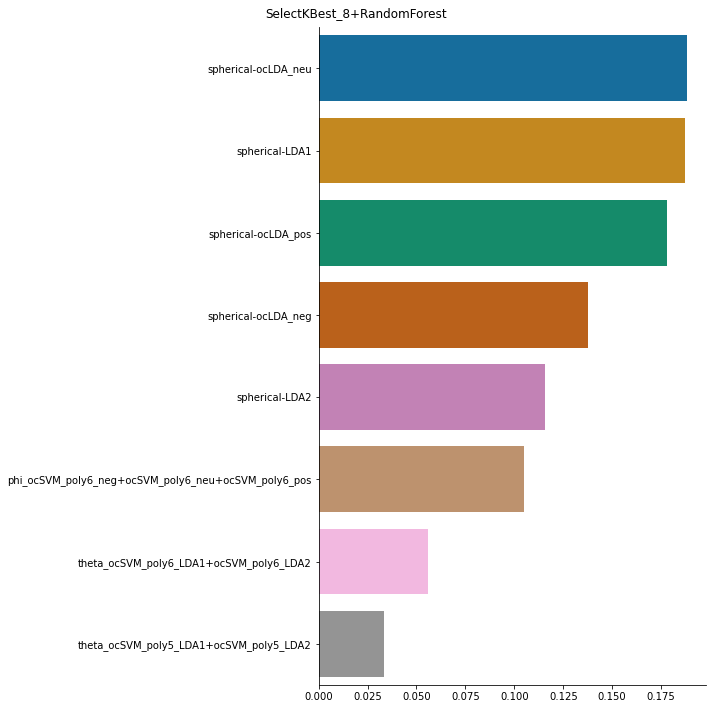

GaussianNB oob score changed by 0.0803 to 0.8630
extra trees oob score changed by -0.0247 to 0.8869
random forest oob score changed by -0.0316 to 0.8955

SelectKBest_8+AdaBoost
accuracy: 0.8774
roc_auc_ovo: 0.8977
log_loss: 0.9957
SelectKBest_8+ExtraTrees
accuracy: 0.9064
roc_auc_ovo: 0.9875
log_loss: 0.2308


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_8+RandomForest
accuracy: 0.9523
roc_auc_ovo: 0.9968
log_loss: 0.1428
SelectKBest_8+GaussianNB
accuracy: 0.8631
roc_auc_ovo: 0.9722
log_loss: 0.8406

with feature selection by SelectKBest_8...
AdaBoost's accuracy changed by 0.0088 from 0.8686 to 0.8774
AdaBoost's roc_auc_ovo changed by -0.0085 from 0.9062 to 0.8977
AdaBoost's log_loss changed by 0.0000 from 0.9957 to 0.9957
ExtraTrees's accuracy changed by -0.0467 from 0.9530 to 0.9064
ExtraTrees's roc_auc_ovo changed by -0.0092 from 0.9967 to 0.9875
ExtraTrees's log_loss changed by 0.0550 from 0.1758 to 0.2308
RandomForest's accuracy changed by -0.0356 from 0.9879 to 0.9523
RandomForest's roc_auc_ovo changed by -0.0029 from 0.9997 to 0.9968
RandomForest's log_loss changed by 0.0579 from 0.0849 to 0.1428
GaussianNB's accuracy changed by 0.0802 from 0.7829 to 0.8631
GaussianNB's roc_auc_ovo changed by 0.0362 from 0.9360 to 0.9722
GaussianNB's log_loss changed by -3.6427 from 4.4833 to 0.8406

selecting with SelectKBest_9


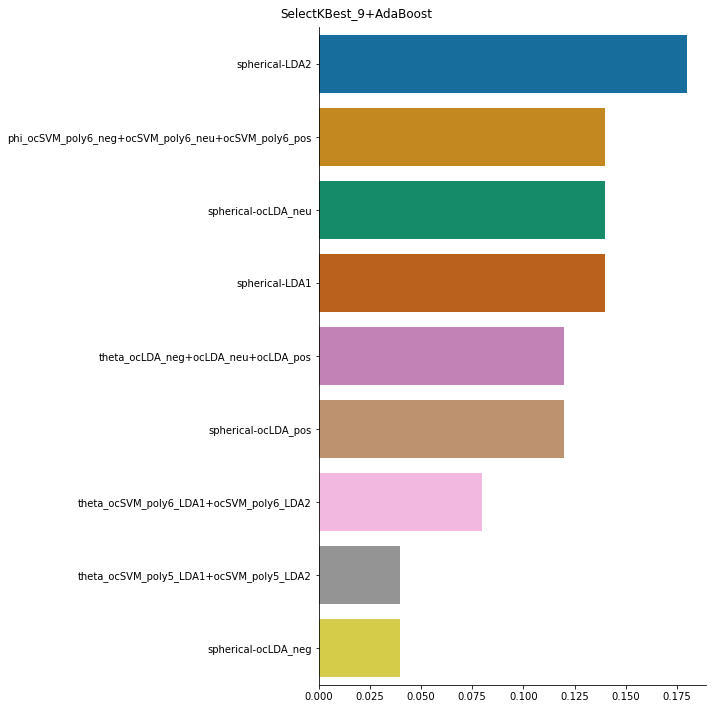

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


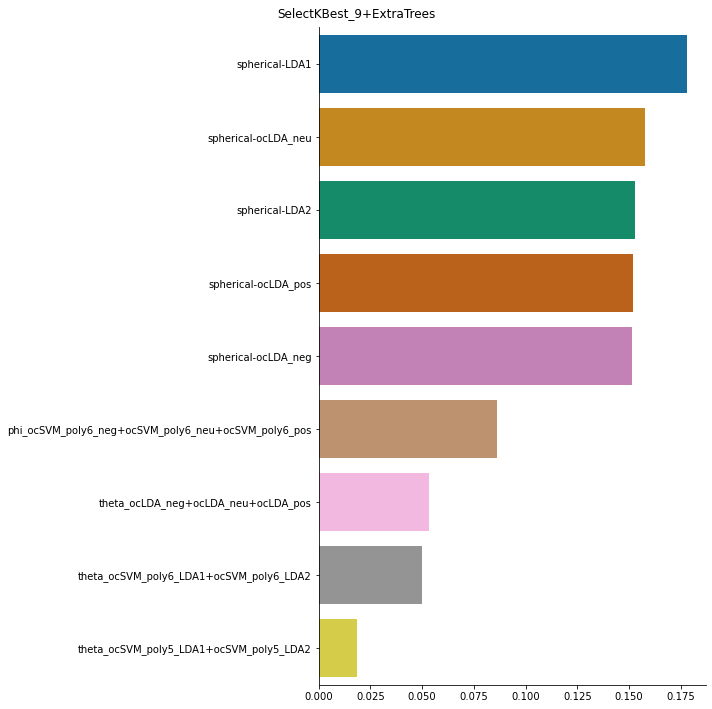

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


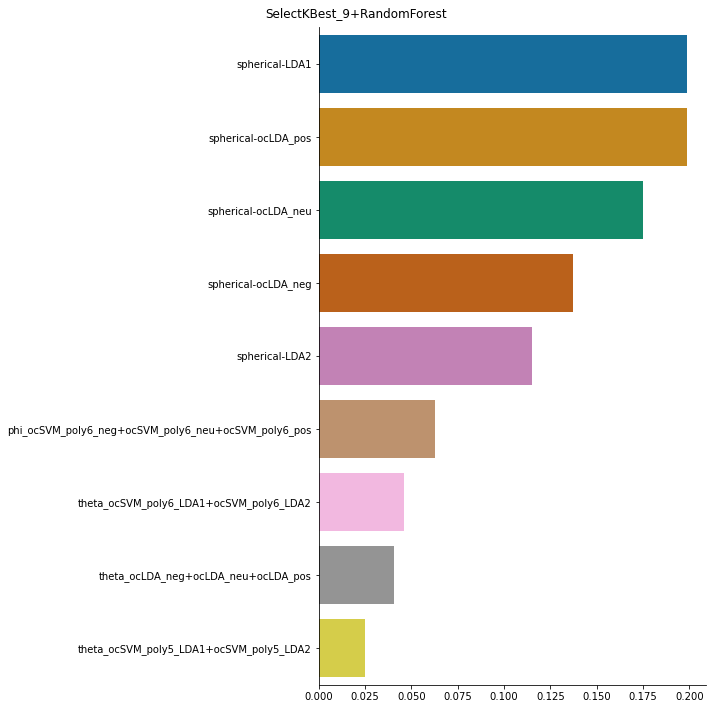

GaussianNB oob score changed by 0.0744 to 0.8572
extra trees oob score changed by -0.0148 to 0.8968
random forest oob score changed by -0.0231 to 0.9040

SelectKBest_9+AdaBoost
accuracy: 0.8603
roc_auc_ovo: 0.8868
log_loss: 0.9693
SelectKBest_9+ExtraTrees
accuracy: 0.9191
roc_auc_ovo: 0.9906
log_loss: 0.2060


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_9+RandomForest
accuracy: 0.9601
roc_auc_ovo: 0.9977
log_loss: 0.1253
SelectKBest_9+GaussianNB
accuracy: 0.8572
roc_auc_ovo: 0.9710
log_loss: 0.9239

with feature selection by SelectKBest_9...
AdaBoost's accuracy changed by -0.0083 from 0.8686 to 0.8603
AdaBoost's roc_auc_ovo changed by -0.0193 from 0.9062 to 0.8868
AdaBoost's log_loss changed by -0.0264 from 0.9957 to 0.9693
ExtraTrees's accuracy changed by -0.0339 from 0.9530 to 0.9191
ExtraTrees's roc_auc_ovo changed by -0.0061 from 0.9967 to 0.9906
ExtraTrees's log_loss changed by 0.0301 from 0.1758 to 0.2060
RandomForest's accuracy changed by -0.0278 from 0.9879 to 0.9601
RandomForest's roc_auc_ovo changed by -0.0020 from 0.9997 to 0.9977
RandomForest's log_loss changed by 0.0404 from 0.0849 to 0.1253
GaussianNB's accuracy changed by 0.0743 from 0.7829 to 0.8572
GaussianNB's roc_auc_ovo changed by 0.0349 from 0.9360 to 0.9710
GaussianNB's log_loss changed by -3.5594 from 4.4833 to 0.9239

selecting with SelectKBest_10


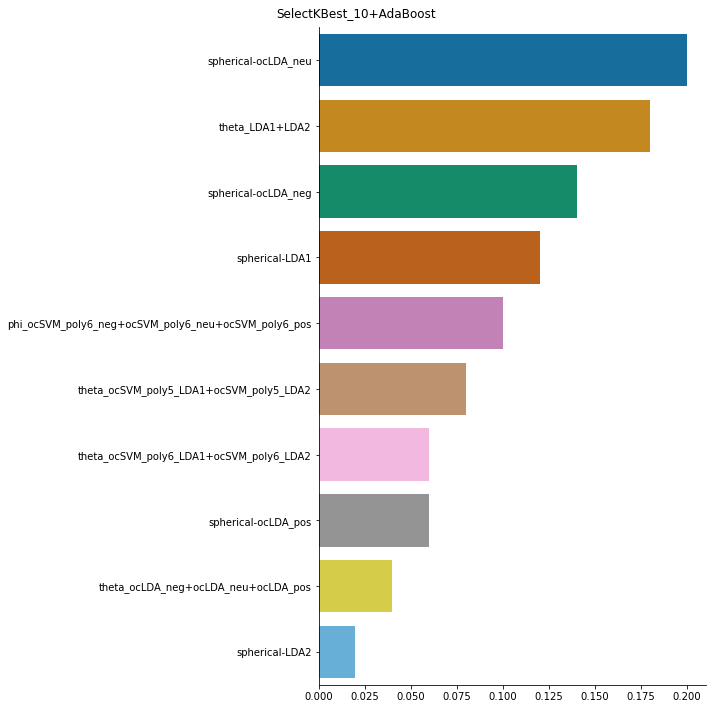

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


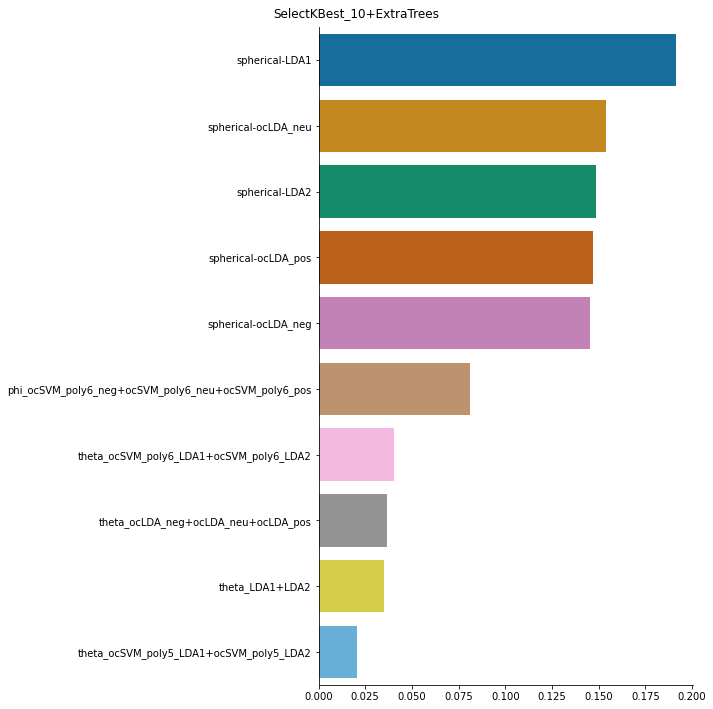

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


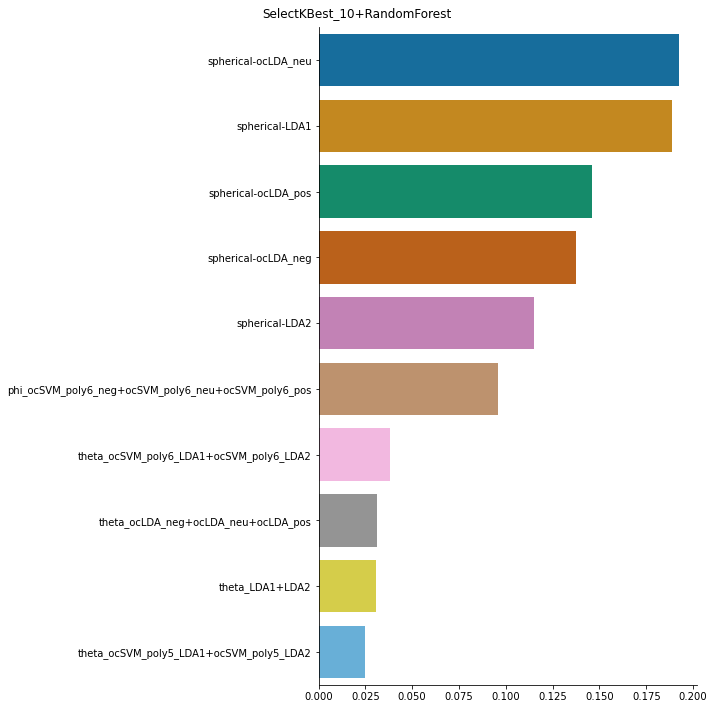

GaussianNB oob score changed by 0.0668 to 0.8496
extra trees oob score changed by -0.0132 to 0.8983
random forest oob score changed by -0.0224 to 0.9047

SelectKBest_10+AdaBoost
accuracy: 0.8796
roc_auc_ovo: 0.8870
log_loss: 0.9881
SelectKBest_10+ExtraTrees
accuracy: 0.9203
roc_auc_ovo: 0.9908
log_loss: 0.2043


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_10+RandomForest
accuracy: 0.9607
roc_auc_ovo: 0.9978
log_loss: 0.1226
SelectKBest_10+GaussianNB
accuracy: 0.8495
roc_auc_ovo: 0.9691
log_loss: 1.0451

with feature selection by SelectKBest_10...
AdaBoost's accuracy changed by 0.0110 from 0.8686 to 0.8796
AdaBoost's roc_auc_ovo changed by -0.0191 from 0.9062 to 0.8870
AdaBoost's log_loss changed by -0.0076 from 0.9957 to 0.9881
ExtraTrees's accuracy changed by -0.0328 from 0.9530 to 0.9203
ExtraTrees's roc_auc_ovo changed by -0.0059 from 0.9967 to 0.9908
ExtraTrees's log_loss changed by 0.0285 from 0.1758 to 0.2043
RandomForest's accuracy changed by -0.0272 from 0.9879 to 0.9607
RandomForest's roc_auc_ovo changed by -0.0019 from 0.9997 to 0.9978
RandomForest's log_loss changed by 0.0377 from 0.0849 to 0.1226
GaussianNB's accuracy changed by 0.0667 from 0.7829 to 0.8495
GaussianNB's roc_auc_ovo changed by 0.0330 from 0.9360 to 0.9691
GaussianNB's log_loss changed by -3.4383 from 4.4833 to 1.0451

time: 19min 38s


In [18]:
data = load_data()
fitted_trees = fit_trees(data, y_true)
selectors = {
    f"SelectKBest_{k}": SelectKBest(score_func=mutual_info_classif, k=k)
    for k in range(1, 11)
}
for selector_estimator, selector in selectors.items():
    print(f"selecting with {selector_estimator}")

    data_ = pd.DataFrame(
        selector.fit_transform(data, y_true),
        columns=selector.get_feature_names_out(data.columns),
    )
    fitted_models: Dict[str, BaseEstimator] = {}

    for ensemble_name, fitted_tree in deepcopy(fitted_trees).items():
        fitted_models[
            f"{selector_estimator}+{ensemble_name}"
        ] = fitted_tree.fit(  # re-fit
            data_, y_true
        )
        plot_importances(
            fitted_tree, fig_height=10, title=f"{selector_estimator}+{ensemble_name}"
        )
    fitted_models[f"{selector_estimator}+GaussianNB"] = make_gnb().fit(data_, y_true)
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models[f'{selector_estimator}+GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_models[f'{selector_estimator}+ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_models[f'{selector_estimator}+RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()

    scores_after: Dict[str, Dict[str, float]] = {
        k: score_model(v, k, data=data_) for k, v in fitted_models.items()
    }

    print(f"\nwith feature selection by {selector_estimator}...")
    for after_model, after_score_dict in scores_before.items():
        after_scores: Dict[str, float] = scores_after[
            f"{selector_estimator}+{after_model}"
        ]
        before_scores: Dict[str, float] = scores_before[after_model]
        base_model = after_model.split("+")[-1]
        for scorer, score in after_scores.items():
            print(
                f"{base_model}'s {scorer} changed by {(after := after_scores[scorer]) - (before := before_scores[scorer]):.4f} from {before:.4f} to {after:.4f}"
            )
    print()

# Discussion

The top 5 spherical LDA features work best for GaussianNB. Using just the two big spherical LDAs might be even better.

The OOB performance of the ensemble models, particularly RF, is really good on the full set. It shouldn't be too costly to train two prototypes: one with a GaussianNB and the other with RandomForest. Note that there is speaker leakage when using OOBE rather than the custom predetermined 5-fold CV.

Next steps:
* brief hyperparameter tuning using OOBE rather than CV
* train prototypes
* preproocess and evaluate hold-out data

There are so many more possibilities for feature engineering. LDA components of information distilled by other classifiers are some of the best features. LDA components could be extracted from all per-class features grouped by valence. LDA components of non-sphericals or just the LOF features could be good too.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are sticking with the feature engineering pathway we already established.

Upstream augmentation of the raw audio would probably be helpful as would resampling.

Interestingly, spherical-LDA1 and spherical-LDA2 aren't making it to the tops when we use SelectFromModel with AdaBoost.

In [19]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 1910.119865179062 s
time: 163 ms


[^top](#Contents)